In [1]:
import re
import nltk
import spacy
import emoji
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from wordcloud import STOPWORDS
from wordcloud.wordcloud import WordCloud
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
rcParams['figure.figsize'] = (15, 10)
sns.set(font_scale=1.5)
sns.set_theme(context='talk')

In [3]:
com_df = pd.read_csv('../data/comments_info.csv')
tweet_df = pd.read_csv('../data/tweets_info.csv')

cols_to_datetime = ['tweet_created', 'account_created']
df = pd.concat([tweet_df, com_df], axis=0, ignore_index=True)

### Text EDA & Cleaning

In [4]:
df.head()

,tweet_created,conversation_id,tweet_id,author_id,text,retweet_count,reply_count,like_count,quote_count,account_created,account_id,name,verified,follower_count,following_count,tweet_count,listed_count
0,2022-06-09T23:23:33.000Z,1535039928752537618,1535039928752537618,361289499,"There's less than 100,000 blocks until the nex...",423,247,2652,13,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757
1,2022-06-09T22:18:54.000Z,1534926244369817601,1535023660301398016,361289499,Looking for #Bitcoin gear? We've got you cover...,30,34,133,2,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757
2,2022-06-09T21:04:36.000Z,1534953242878259202,1535004962417037312,361289499,Stay up to date on the latest #Bitcoin news wi...,26,28,86,1,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757
3,2022-06-09T20:28:23.000Z,1534995848278466565,1534995848278466565,361289499,"RT @mcshane_writes: In mathematics, the pigeon...",47,0,0,0,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757
4,2022-06-09T20:16:55.000Z,1534992962425192448,1534992962425192448,361289499,RT @BitcoinMagazine: @saylor @MicroStrategy Th...,44,0,0,0,2011-08-24T15:14:54.000Z,361289499,Bitcoin Magazine,True,2507182,757,23373,13757


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33866 entries, 0 to 33865
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_created    33866 non-null  object
 1   conversation_id  33866 non-null  int64 
 2   tweet_id         33866 non-null  int64 
 3   author_id        33866 non-null  int64 
 4   text             33866 non-null  object
 5   retweet_count    33866 non-null  int64 
 6   reply_count      33866 non-null  int64 
 7   like_count       33866 non-null  int64 
 8   quote_count      33866 non-null  int64 
 9   account_created  33866 non-null  object
 10  account_id       33866 non-null  int64 
 11  name             33865 non-null  object
 12  verified         33866 non-null  bool  
 13  follower_count   33866 non-null  int64 
 14  following_count  33866 non-null  int64 
 15  tweet_count      33866 non-null  int64 
 16  listed_count     33866 non-null  int64 
dtypes: bool(1), int64(12), object(4

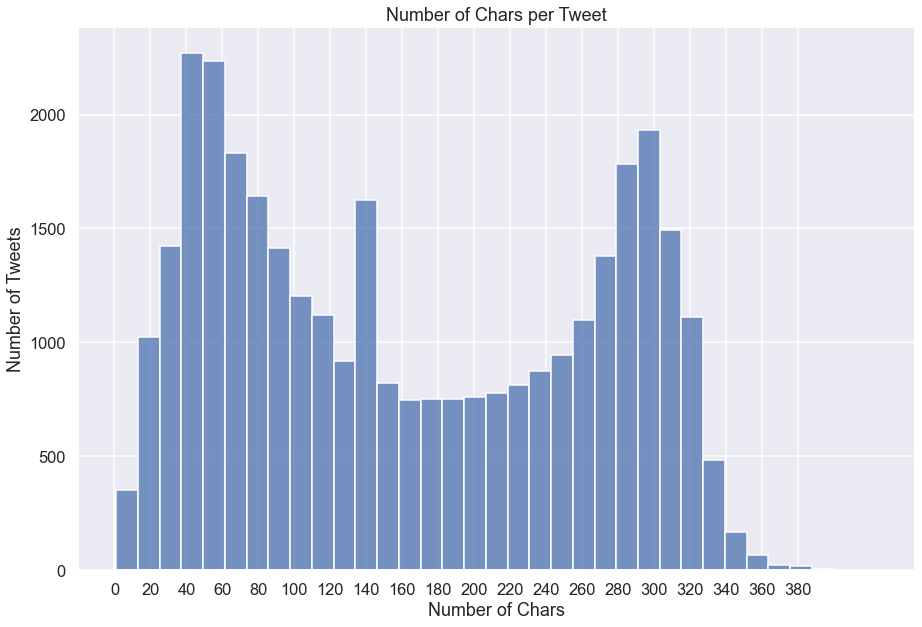

In [6]:
# let's look at the number of characters per tweet
sns.histplot(df['text'].str.len())
plt.xticks(list(range(0, 400, 20)))
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Twitter allows max 280 characters per tweets, so all the tweets with more than 280 char must contain either a lot of mentions (@someone) or links. We can also observe large amount of tweets with low number of chars. This might be caused either by stopwords, slang or something else, they might not hold a lot of meaning.
##### TODO
1. Remove Mentions (e.g. @coinbase)
2. Remove leading RT (stands for retweeted)
3. Remove leading hashtag sign
4. Remove spaces etc
5. Remove all chars but ascii and emoji

In [7]:
# let's look at the actual test and see what makes tweets surpass 280 mark
df[df['text'].str.len() > 320].text.values[1]

"@IndiraKempis @senadomexicano Subscribe to Bitcoin Magazine's FREE daily newsletter and get the latest news delivered right to your inbox!\n\nToday's edition covered:\n🏡 Home mining experts talk strategy\n🏛️ Fort Worth, TX vote on bitcoin mining bill\n🐒 Costa Rica's bitcoin jungle\n\n👇📰\nhttps://t.co/XpRwZUa1it https://t.co/VTpKm1LcaY"

In [8]:
good_chars = string.printable +  ''.join(emoji.EMOJI_DATA.keys())

In [9]:
# let's remove mentions, so we can see the actual text of the tweet, and look at the graph again
df['text'].replace(r"@[^\s]+", ' ', regex=True, inplace=True)  # removing mentions @
df['text'].replace(r'RT ', '', regex=True, inplace=True) # removing RT (retweeted)
df['text'].replace(r'JUST IN ', ' ', regex=True, inplace=True) # common pattern
df['text'].replace(r'JUST IN: ', ' ', regex=True, inplace=True) # common pattern
df['text'].replace(r'BREAKING: ', ' ', regex=True, inplace=True)
df['text'].replace(r'BREAKING ', ' ', regex=True, inplace=True)
df['text'].replace(r'NEW: ', ' ', regex=True, inplace=True)
df['text'].replace(r'NEW ', ' ', regex=True, inplace=True)
df['text'].replace(r'ICYMI: ', ' ', regex=True, inplace=True)
df['text'].replace(r'ICYMI ', ' ', regex=True, inplace=True)
df['text'].replace(r'TOMORROW: ', ' ', regex=True, inplace=True)
df['text'].replace(r'TOMORROW: ', ' ', regex=True, inplace=True)
df['text'].replace(r'COMING UP: ', ' ', regex=True, inplace=True)
df['text'].replace(r'COMING UP ', ' ', regex=True, inplace=True)
df['text'].replace(r'LIVE: ', ' ', regex=True, inplace=True)
df['text'].replace(r'LIVE ', ' ', regex=True, inplace=True)
df['text'].replace(r'#', '', regex=True, inplace=True)  # remove hashtags
df['text'].replace(r'http\S+', ' ', regex=True, inplace=True)  # removing links
df['text'].replace(r'&[A-Za-z0-9#]+;', ' ', regex=True, inplace=True) # removing html character reference
df.text.replace({fr'[^{good_chars}]':' '}, regex=True, inplace=True) # removing all but ascii and emojis
df['text'].replace('|'.join(string.whitespace), ' ', regex=True, inplace=True)  # remove all the whitespace chars
df['text'].replace(r'\s+', ' ', regex=True, inplace=True)  # strip extra spaces

In [10]:
df.text.sample(10)

32424                                Good morning Keith 💐💞
4968      brings together the global community of desig...
15913     💥 Massive Airdrop event by is on-going right ...
18352     [$DOGECOIN] is the Buff version of $DOGE. Buf...
24712     Just make sure you respect supply and demand....
9372                                                      
25976     RET ❤ is the best project Solar power plants ...
12261     Please support me RT Hi Im just someone who t...
27981                             Great mind thinks alike!
32340                                                   Gm
Name: text, dtype: object

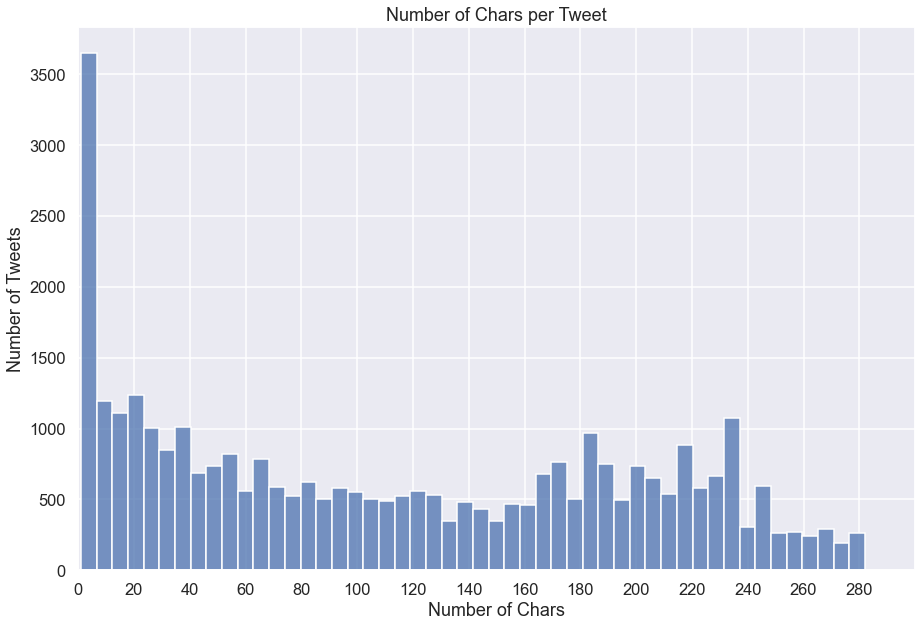

In [11]:
sns.histplot(df['text'].str.len(), bins=50)
plt.xticks(list(range(0, 290, 20)))
plt.xlim(0, 300)
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Now we see that all the tweets fall within the limit of 280 chars, but the number of tweets with less than 20 chars has increased drastically.

In [12]:
# let's see what we can fit in within 20 chars
sample_text = 'Market is going to crash'
print(f'Length of this text "{sample_text}" is {len(sample_text)} chars.')

Length of this text "Market is going to crash" is 24 chars.


###### I would think that tweets that have less than 15-20 chars are meaningless. Let's explore what kind of tweets have a few characters

In [13]:
print('Number of empty string',len(df[df['text'].isin(['', ' '])].text))
df = df[~df['text'].isin(['', ' '])]

Number of empty string 2046


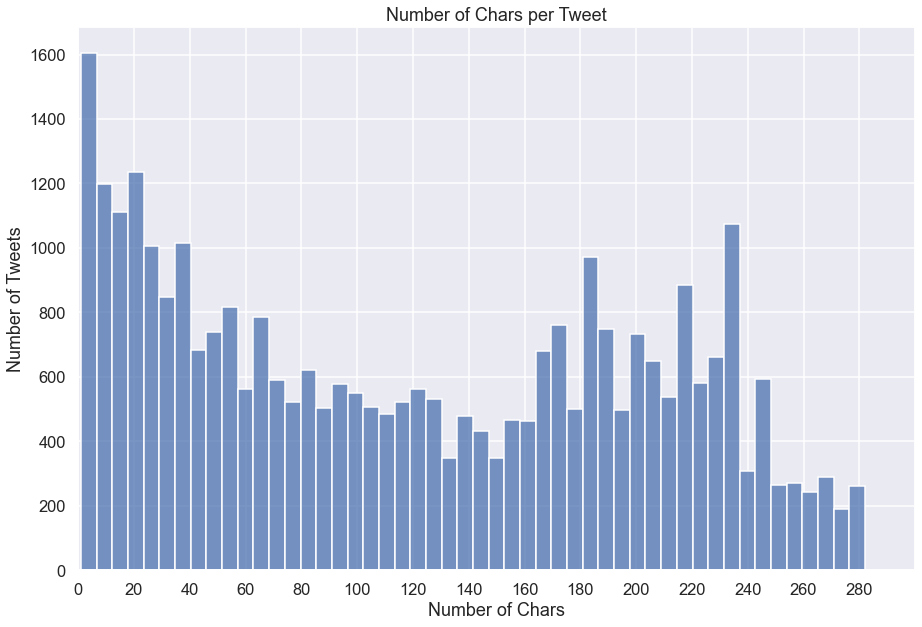

In [14]:
sns.histplot(df['text'].str.len(), bins=50)
plt.xticks(list(range(0, 290, 20)))
plt.xlim(0, 300)
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Great, we cut the number of tweets with less than 20 by a third. Although, we have to keep in mind that a lot of tweets that we get are meaningless, and we might have to extract more information. Let's continue to explore tweets with low number of words.

In [15]:
df[df.text.str.len() < 20].text.value_counts().head(40)

 gm                    129
 Thank me later        102
 Gm                     97
 👇                      74
 😂                      30
 👀                      26
 Join the chat💬👇        23
 ❤️                     22
 GM                     19
 Bitcoin $paw           18
 Web 3                  16
 Worth reading $paw     16
 Join 💬chat to earn     16
 TRX TRON USDD          16
 😂😂😂                    15
 Gm gm                  14
 Gm!                    14
 gm                     13
 Good                   13
 Gm ser                 12
 Slot hNFT NFT ENS      10
 Bitcoin                10
 🤣🤣🤣                    10
 $PAW                    9
 Lol                     9
 TRV Blockchain          9
 Yes                     9
 gm!                     9
 lol                     9
 🔥🔥🔥                     8
 🤌🏻                      8
 Great                   8
 😍                       8
 Awesome                 8
 🤣                       7
 Inbox me                7
 GUYS GO GO GO👉          7
 

###### We can observe that greeting (gm) is quite common in bitcoin community, but to us, it does not hold much value, so let's get rid of it. As well as 'Thank me later'

In [16]:
# dropping common patterns like 'gm|Gm|GM|Thank me later'
print(f"gm/thank me later like occurrences where char len is less than 20: {df[(df.text.str.contains(r'gm|Gm|GM|Thank me later', regex=True)) & (df.text.str.len() < 20)].__len__()}")
df = df[~((df.text.str.contains(r'gm|Gm|GM|Thank me later', regex=True)) & (df.text.str.len() < 20))]

gm/thank me later like occurrences where char len is less than 20: 795


In [17]:
print(f'# comments < 20 chars {df[df.text.str.len() < 20].text.shape}')
print(f'total comments {df.text.shape}')
df[df.text.str.len() < 20].text.value_counts().head()

# comments < 20 chars (3549,)
total comments (31025,)


 👇                   74
 😂                   30
 👀                   26
 Join the chat💬👇     23
 ❤️                  22
Name: text, dtype: int64

###### We see that we still have over 3k comments shorter than 20 chars, which makes it roughly 100 comments per 1000 comments or every 10th
##### TODO
1. Convert emojis to text
2.  Get rid of spam comments
3. Think how to assign meaning to one word emotions
4. We yet have not dealt with special characters

In [18]:
# let's convert emojis to words

In [19]:
# let's look at all the tweets that have emojis
emoji_df = df[df.text.str.contains(r'|'.join(map(re.escape, list(emoji.EMOJI_DATA.keys()))), regex=True)]

In [20]:
emoji_df.text.sample(10)

15314     Soon, Coinerr will launch the E-Bank service ...
21866     🐸 Ninja Frog Inu 🐸 ✅ HYPER COMMUNITY ✅ ENMT U...
18636     🐸🐸FROGNOBI INU🐸🐸 ✅Low Mc now Ca : 0x51b46f0FF...
17224     [$DOGECOIN] is the Buff version of $DOGE. Buf...
6312      is a project inspired by Goblin Town aRAgrgrG...
21282     GEM ALERT!!! Kindly check out $FCK Best gem o...
12416     Guys, you should check out It s a 🔥 project T...
24933     ShibaKing(SHK) is a project drive mass adopti...
27447                                          oink oink 🐽
28580     Bitgert Brise The Blockchain of the Future 🚀🚀...
Name: text, dtype: object

In [21]:
# let's demojize these tweets and see what is does
demojized_df = emoji_df.copy(deep=True)
demojized_df.loc[:, 'text'] = demojized_df.text.apply(lambda row: emoji.demojize(row))

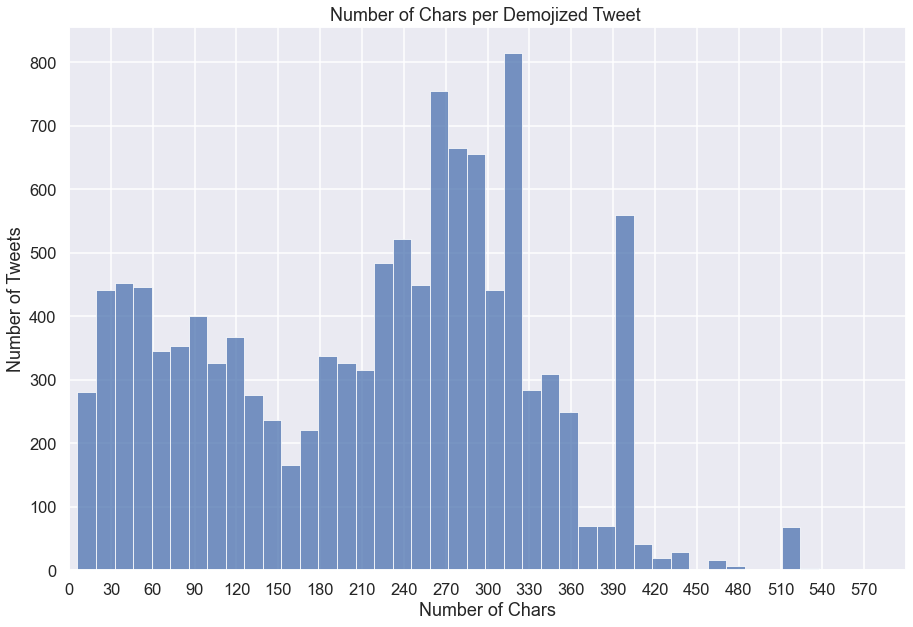

In [22]:
sns.histplot(demojized_df.text.str.len(), bins=100)
plt.xlim(0, 600)
plt.xticks(list(range(0, 600, 30)))
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Demojized Tweet ');

###### We can see how it increases number of chars per tweet, lets take a closer look at the outliers

In [23]:
# let's take a look at the tweets that exceed 300 chars (we will give a buffer of 20 chars)
emoji_outliers = demojized_df[demojized_df.text.str.len() > 300].text.map(lambda row: emoji.emojize(row))
emoji_outliers.value_counts().head(10)

 🪐 WELCOME TO BEERUSX100 🔥 ✅ KYC Audit ✅ No team tokens ✅ Liquidity will be locked after listing ✅ Ownership will be renounced ✅ Lowcap presale ✅ Tax 4% (buy/sell) 👉 Contract: 👉 ILO : 🌎                                                                503
 🚨IDO ALERT🚨 is pleased to announce the IDO of on the 15th of June at 12 PM UTC! All you need to know about is; 💎 Total tokens for sale: 600,000 EMT 💰 Total Raise: 1,200,000$ 💵 IDO Price: 0.05$ 🚀 Initial MC at TGE: 217,000$ BNB crypto               415
 💎 Introducing Bit-Luna 0.5 token, the heir to the Luna fortune - Join us for 1000x gains 💰Total Supply: 10,000,000,000 💊 9% BUY / 15% SELL TAX 💊 SAFU: LIQUIDITY LOCKED 100% 💊 AUDIT + KYC 💊 WHITEPAPER 💊 VERIFIED CONTRACT 💊 RARE NFTS 📌 Telegram:     116
 ✅ World First USE -2- EARN Ecosystem. ✅ 🚀 Alpha App Live 📲 No Private Sale 📲 Contract Verified 📲 Audit By ContractWolf 📲 KYC'd By Doxxed 📲 Partnership With Coinhunt,NABOX, IKONIC, parrot bamboo                                               

In [24]:
df.text.value_counts().head(10)

 🪐 WELCOME TO BEERUSX100 🔥 ✅ KYC Audit ✅ No team tokens ✅ Liquidity will be locked after listing ✅ Ownership will be renounced ✅ Lowcap presale ✅ Tax 4% (buy/sell) 👉 Contract: 👉 ILO : 🌎                                                                                       503
 🚨IDO ALERT🚨 is pleased to announce the IDO of on the 15th of June at 12 PM UTC! All you need to know about is; 💎 Total tokens for sale: 600,000 EMT 💰 Total Raise: 1,200,000$ 💵 IDO Price: 0.05$ 🚀 Initial MC at TGE: 217,000$ BNB crypto                                      415
 📌🔥 CRYPTO ASSISTANT 🔥 Crypto Assistant is a platform where you can find all crypto token information in one place,clearly arranged in one agenda... Web: TG: 🟢8% buy sell tax 🟢LP locked 🟢Kyced Audited 🟢presale: 6/17/2022                                                    289
 🐕 $DOGGER 🐕 Dogger aims to be the first decentralized and open source social media platform for the crypto world ☑️ A greatly improved contract ☑️ Huge staking rewards ☑️ 

###### Wow, if we compare duplicates in main dataframe and dataframe with emojis that have too many characters, we can see that the top duplicates are identical. This signifies that most of the spam comments will be using extensive amount emojis. We should be getting rid of the extensive number of duplicate comments from the main df  (maybe over ~20 duplicates) in the beginning of preprocessing to speed up the process.
##### We should try different thresholds, I think a good starting point is 20 duplicates, however we need to keep in mind that spam comments might influence human behaviour.

In [25]:
df.text.value_counts().describe()

count    20518.000000
mean         1.512087
std          6.167112
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        503.000000
Name: text, dtype: float64

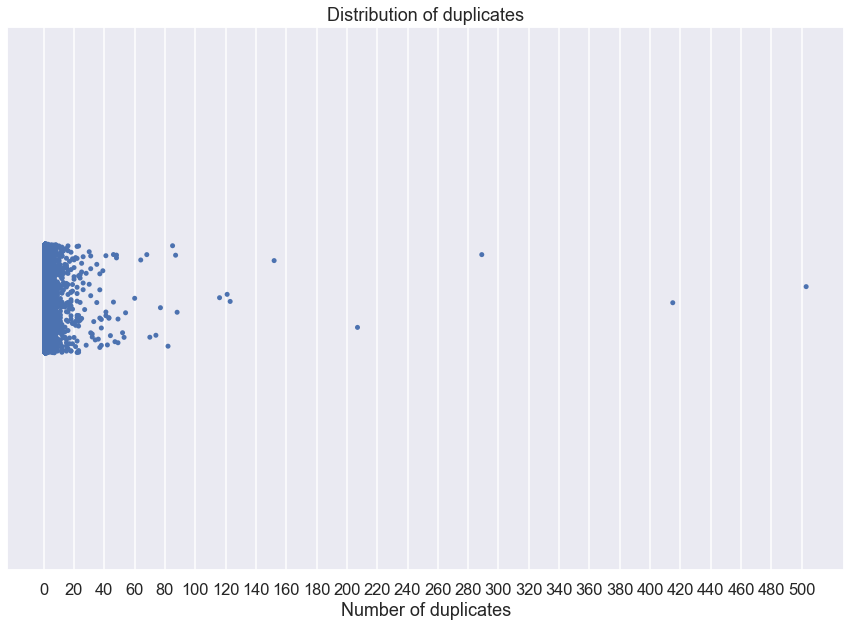

In [26]:
# let's visualize distribution of the duplicate tweets
sns.stripplot(x=df.text.value_counts().to_numpy(), )
plt.title('Distribution of duplicates')
plt.xticks(list(range(0, 520, 20)))
plt.xlabel('Number of duplicates');

In [27]:
# let's read some tweets
df.text.value_counts().reset_index(name='counts').loc[1010: 1030, :]

,index,counts
1010,Best way to earn from crypto trading?Send a m...,3
1011,"Put $1000 in your bank,next month you may hav...",3
1012,Amazing $paw,3
1013,$paw,3
1014,", 1000 USDT 0x385418f3b388eb432c40806f7908194...",3
1015,😑,3
1016,Great project cmcx core coremultichain CMCX C...,3
1017,"Fox News ran 1,098 primetime segments on Beng...",3
1018,Professional Web Hosting Low Price Hosting + ...,3
1019,Gm🥰 🤝Btc Cpos Family❣️ movetoCPOS to EARN mor...,3


###### We can see that even when there are only two duplicates, a majority of them are still spam comments. So we definitely should start with the threshold of 2 duplicates instead of 20 lol

In [28]:
# keeping only tweets that repeat no more than twice
df = df[~df['text'].isin(df['text'].value_counts().loc[lambda cnt: cnt > 2].index)]

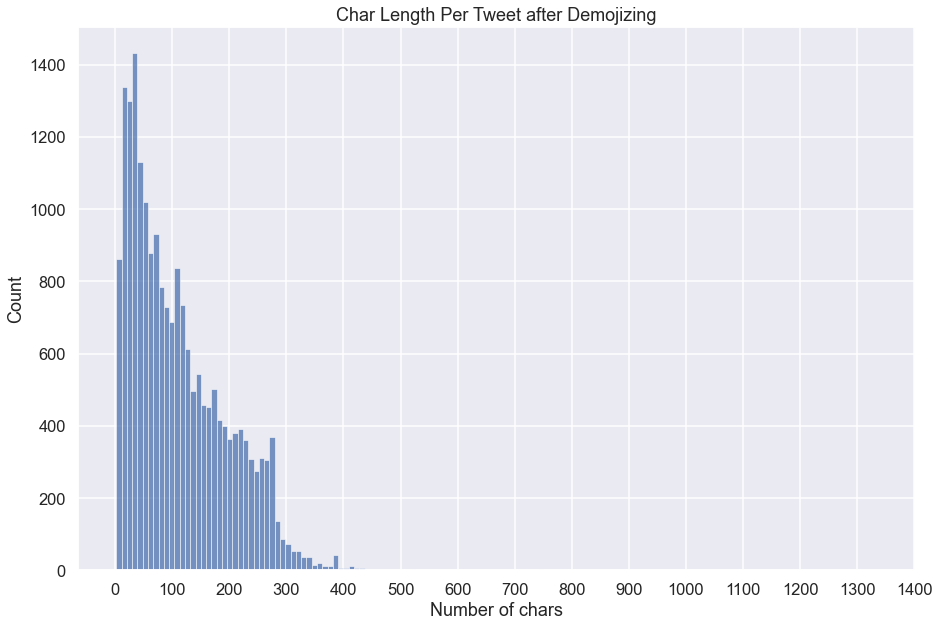

In [29]:
# now we can convert emoji to text
demojized_df = df.text.apply(lambda row: emoji.demojize(row))
sns.histplot(demojized_df.str.len())
plt.xticks(list(range(0, 1500, 100)))
plt.title('Char Length Per Tweet after Demojizing')
plt.xlabel('Number of chars');

###### we keep observing outliers after demojizing tweets, let's look into those outliers.

In [30]:
df.loc[demojized_df.str.len().sort_values(ascending=False) > 280, 'text'].sample(10)

27906     🧪Project 🧪Token-MoonLabs $MLABS 🧪Supply-10000...
13478     $MVE launched less than two weeks, at about $...
23352     As a busy person, investing and getting retur...
6833      The team at SectorProtocol has a mission to c...
6858      MobiPad total supply 100 million new diamonds...
28053     The $250,000 +$Cake in $MONSTA vault started ...
30504     🔥 BOBAMASK is the Future of Defi Wallets ⚡ 1️...
10874     MEVR TOKEN ✅Total supply 100 million ✅Burn 50...
28118     The chance of getting scammed is way bigger i...
16537     Cryptocurrencies and other digital coins won'...
Name: text, dtype: object

###### we can see that even though 1-2 comments are genuine, the majority of them are spam as well. So that will be our second spam check. We will have to convert emoji to text first in this case.

In [31]:
df.loc[:, 'text'] = df['text'].apply(lambda row: emoji.demojize(row))

In [32]:
# now we will get rid of the tweets with more than 280 chars because there is a high chance of them being spam
df = df[df.text.str.len() < 280]

In [33]:
df[df.text.str.len() > 275].text.apply(lambda row: emoji.emojize(row)).sample(10)

15175     Cool story bro, now we inflate the currency t...
30383     Simple exchange of BlueBit to buy/sell BlueSp...
12556     Crafty Metaverse | $CMETA 🕹️ 3D Play-To-Earn ...
21102     BTC cannot be stolen with the correct measure...
30381     Simple exchange of BlueBit to buy/sell BlueSp...
26503     Allowing broker-dealers to provide a comprehe...
20859     Bitcoin is a long term asset, those in Bitcoi...
28081     The wisest thing that should be on everyone's...
6626      RET RenewableEnergyToken The first token with...
16407     Tem que pressionar os deputados. Votar logo e...
Name: text, dtype: object

###### Now if we look at some samples with the highest number of chars, most of the tweets are genuine, though some of the spams still persist

In [34]:
# for now let's convert demojized text back to emoji until we deal with low char count comments
df.loc[:, 'text'] = df['text'].apply(lambda row: emoji.emojize(row))

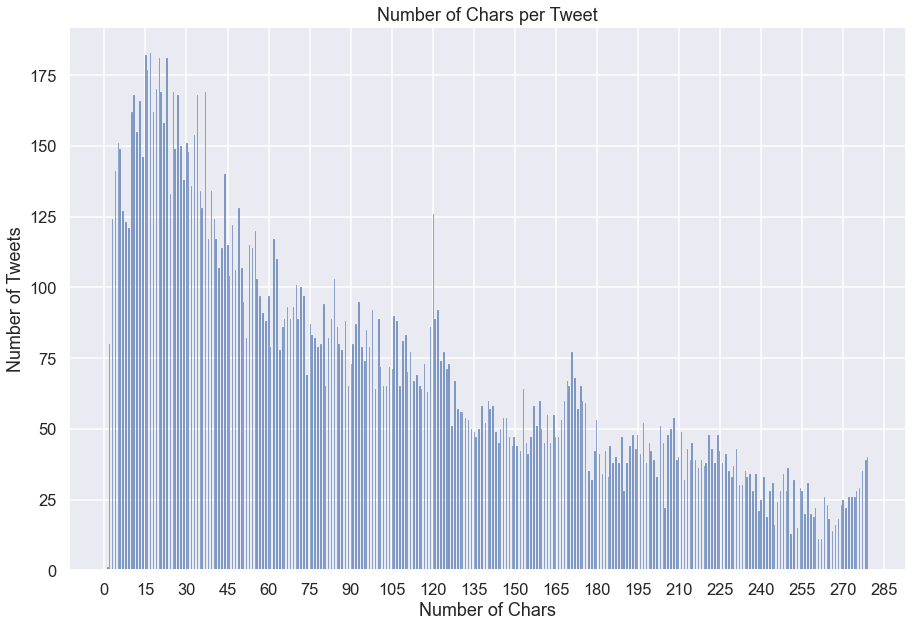

In [35]:
sns.histplot(df['text'].str.len(), bins=500)
plt.xticks(list(range(0, 295, 15)))
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### It looks like we were able to even out the distribution a little more, deal with some problematic long tweets, but we have not achieved as mush success with short tweets. Let's take a closer look with what kind of text we are working with.

In [36]:
short_tweets = df.loc[df[df.text.str.len() < 20].text.str.len().sort_values().index, :]
print(f'Length of short_tweets {len(short_tweets)}')
print(short_tweets.text.sample(400).tolist())

Length of short_tweets 2688
[' No KYC', " It's too slow", ' Bitcoin is Vapour ', ' Dm', ' 🦉💣', ' \U0001fae2\U0001fae2', ' Hello Texas', ' Musk?', ' So good!', ' bearish', ' MEFI', ' Never forget', ' 👇👇👇 ', ' Good morning!', ' So cool!', ' You know nothing. ', ' art floor', ' RET ❤️❤️❤️ ', ' how ironic of you.', ' Thank you hunny', ' For what? Why?', ' this i know', ' is full of $hit', ' A+', ' ♥️♥️', ' \U0001faf6', " It's a 🐋", ' This is good', ' MLM or pyramid?', ' 😬', ' Bingo', ' Fuck Fiat', ' On average, yes', ' Time will tell', ' Thank God $paw', ' wat', ' 😹', ' Wow', ' Happy Sunday fam. ', ' solid choice', ' Bullish!', ' Try', ' Say what? 😎', ' What is this? Spam', ' is a fvcking liar', ' Or.. :) ', ' Bitcoin Bitcoin ', ' Fucking bitcoin!', ' LUNC🔥', ' likewise!', ' Hi!', ' 👇\U0001fae2 ', ' Galaverse', ' Great read', ' Possibly not', ' 🤪👈', ' 100%!', ' HFSP', ' ez ratio', ' 🤗🤗', ' ?????????? Need', ' ☺️💖', ' I will be there!', ' June7th', 'sTaBlEcOiN ', ' 👀🚀🍻', ' 👀😳', ' Perfect pr

###### We can see that most of it is useless, but as the number of chars increases, we can derive some meaning. We have the following options.
1. Remove tweets which have less than n number of chars, where n is ~ 20
2. Do a lot of regex to try match most common patterns and get rid of them
3. Extract comments that have adjectives (maybe something else) using nltk library, get rid of the rest. Without context many single adjectives might skew our average sentiment. Therefore, we can prepend the original tweet to the adjective. That way, our model will have more context and an emotion/reaction about it in the end. It could be a good guidance for classifying ambiguous original tweets.
4. Lastly, when averaging our sentiments, we can assign lower weights to comments with low number of characters.

In [37]:
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
# let's see what speech tags nltk library offers us and what we find most useful
short_tweets.text.apply(lambda row: str(nltk.pos_tag(nltk.word_tokenize(row)))).sample(20)

9876                                         [('🎉', 'NN')]
12143                       [('LFG', 'NNP'), ('🚀🚀', 'NN')]
21676    [('True', 'NN'), (',', ','), ('he', 'PRP'), ("...
11731                        [('great', 'JJ'), ('.', '.')]
11412                                       [('😀😀', 'NN')]
26031                                 [('BabyDoge', 'NN')]
14315    [('Bitcoin', 'NNP'), ('_', 'NNP'), ('(', '('),...
16470     [('Presto', 'NNP'), ('Labs', 'NNP'), ('?', '.')]
10143     [('oh', 'UH'), ('maybe', 'RB'), ('maybe', 'RB')]
32485    [('Can', 'MD'), ('t', 'VB'), ('wait', 'NN'), (...
24153                               [('🦉🏴\u200d☠️', 'NN')]
7623     [('Bots', 'NNS'), ('everywhere', 'RB'), ('!', ...
33260    [('You', 'PRP'), ('can', 'MD'), ('live', 'VB')...
9564                                       [('FFS', 'NN')]
18805                                        [('S', 'NN')]
28290                                        [('🌕', 'NN')]
17914       [('this', 'DT'), ('i', 'NN'), ('know', 'VBP'

###### We can see that we cannot rely on nouns (NN) because most of the trash contains a noun. I think we might be interested in:
* JJ - Adjective
* RB - Adverb

In [38]:
# let's take a look at adverbs but not adjectives
print(short_tweets[short_tweets.text.apply(lambda row: str(nltk.pos_tag(nltk.word_tokenize(row)))).str.contains(r'(?!JJ)RB', regex=True)].text.sample(50).values)

[' yes exactly.' ' make money easily ' ' Good only just Y'
 ' This WILL age well' ' Disgusting how' ' When?' ' Mining not needed.'
 ' From where?' ' So correct $PAW' ' Why what happened?'
 ' This is very true!' ' Absolutely 👍' ' *wheat, not weak'
 ' So excited 🔥🔥' ' probably nothing ' ' Not at all...😊'
 ' We are so screwed' ' Why not?' ' why ?' ' likewise!'
 ' never heard of him' ' maybe' " Don't trade" ' truly amazing'
 ' Now do longevity' ' Very graphic' ' When is launch?' ' This is so cool'
 ' wow very cool guy ' ' I love $RBTC!' ' almost all? 🥳' ' so true'
 " Don't miss it ! " ' It s just math' ' Too much time 😂🤣' ' So'
 ' Very good' ' How do you do it?' ' Then went bust' ' Jay-Z is so cool'
 ' Love this so much' ' You too' ' Here: 👊⚡ ' ' How u know?' ' How'
 ' Here comes $0.41' ' So is gold then?' ' when EU? 2030?'
 ' We need freedom 😜' ' here in the Link']


In [39]:
# not let's look at adjectives
print(short_tweets[short_tweets.text.apply(lambda row: str(nltk.pos_tag(nltk.word_tokenize(row)))).str.contains(r'(?!RB)JJ', regex=True)].text.sample(50).values)

[' Tomorrow: 🤝 🤝 🤝 🤝 ' ' 🤣🤣🤣🤣🤣 facts' ' Btc is dead' ' She said weak'
 ' Sounds legal.' ' Sure thing!' ' That is great' ' e your own ank 🙌 '
 ' difficult' ' Shrek, un ejemplo' ' Good morning dear'
 ' He doesn t get it' ' How many against?' ' Very nice' ' Good one'
 ' It s NOT true!' ' That s right' ' for sure' ' this is awesome'
 ' Very nice 👍🏻' ' very talented' ' wonderful! 👏👏 ' ' bad indeed'
 ' This is majestic.🌹' ' Hahah nice 💚💚💚' ' ret is the best' ' Bullish ✅'
 ' Very informative' ' 😂 excellent' ' true 🤫' ' Are you jealous?'
 ' easy win' ' This is awesome !!' 'great! ' ' fake moneys'
 ' This is very true!' " Let's go! is next!" ' Bullish' ' Bitcoin free'
 ' Its really amazing' ' You re right ! 😉' ' This is bad'
 ' lightning next? :)' ' Good mo' ' Bullish 🚀' ' Excellent point!'
 ' good times ' ' Oh, is this true?' ' Few 👌' ' is super amazing ']


###### It does not seem that neither of them have t0o many spam messages, though to me, it looks like comments with adjectives are more informative. I think if we will be prepending the original tweet to them, we can keep both, because some of the noise will get neglected

In [40]:
adj_short = short_tweets[short_tweets.text.apply(lambda row: str(nltk.pos_tag(nltk.word_tokenize(row)))).str.contains(r'JJ|RB', regex=True)]
print(f'Length of comments filtered by adj|adverb is {len(adj_short)}')
print(adj_short.text.sample(100).values)

Length of comments filtered by adj|adverb is 734
[' When is launch?' ' $ubt 👀 ' ' Happy Sunday fam. ' ' Short '
 ' Here we go' ' Shrek, un ejemplo' ' Optional' ' CAR??? Be careful'
 ' Really???' ' Maybe' ' Thats right' ' blue Chip' ' Real money!'
 ' Only 4 years ?' ' Never forget' ' But much taxes...!'
 " He's right! $PAW" ' Btc is so volatile' ' Great time to DCA'
 ' its real LOL' ' You too!' ' This is bullish!' ' same! Next time ❤️'
 ' So many! ' ' for sure' " It's cool!" ' 👀🐷 PigeInu soon!!!'
 ' Stable coin ' ' Such clowns 🤡' ' When?' ' Why Spell Token ? '
 ' Nah we re good' " It's cool 😎 $PAW" ' Very nice' ' 🤡🤡🤡 bunch of em'
 ' Possibly not' ' much love🥂💓' ' Then went bust' ' This is incredible'
 ' Liberals = cancer.' ' Beautiful ' ' ocean pump it up' ' I like nft '
 ' likewise!' " here's my 1.6 B " ' This is not real.' ' Jay-Z is so cool'
 ' Clean 👀' ' French?' " That's good" ' Btc is dead' ' mental support'
 ' Love this so much' ' When ?' ' really cool' ' 👁️👁️ bitcoin bill.'
 ' A

##### Great! It looks like we are able to get rid of most the garbage comments, and leave only short reactions. Let's try to prepend the original tweets to these replies and see what we get

In [41]:
adj_short = pd.merge(df[['tweet_id', 'text']], adj_short, how='right', left_on='tweet_id', right_on='conversation_id')
adj_short.drop(['tweet_id_x'], axis=1)
adj_short['prepended'] = adj_short['text_x'] + adj_short['text_y']

In [42]:
adj_short[['prepended', 'text_x', 'text_y']].sample(10)

,prepended,text_x,text_y
309,PayPal users can now withdraw bitcoin to exte...,PayPal users can now withdraw bitcoin to exte...,I do not have
650,. has been named the first official layer 1 bl...,. has been named the first official layer 1 bl...,The real 100xgem
627,"MicroStrategy CEO on CNBC: ""If Bitcoin is not ...","MicroStrategy CEO on CNBC: ""If Bitcoin is not ...",Completely agree.
131,"🔴 expands crypto abilities, allowing U.S. user...","🔴 expands crypto abilities, allowing U.S. user...",real btc
522,"One year ago today, the President of El Salvad...","One year ago today, the President of El Salvad...",You are a scam 😂
447,"Remember when the Fed prints another trillion,...","Remember when the Fed prints another trillion,...",How do you know
504,The is investigating whether $BNB token should...,The is investigating whether $BNB token should...,is a SECURITY!!
644,Accepting bitcoin and crypto is a high priori...,Accepting bitcoin and crypto is a high priori...,Adopt it now $paw
297,NaN,NaN,solid choice
272,NaN,NaN,Good morning


In [43]:
adj_short.prepended.isna().sum() / adj_short.__len__()

0.18256130790190736

###### Great! I think this could work, it gives more context to some of the reactions. We see that around 18% of the comments couldn't find its original tweet, so in our pipeline we will be getting rid of such as well. So this is probably would be one of the better ways to deal with short comments. Let's see how a little longer comments look like.

In [44]:
# tweets with 20 < chars < 30
df.loc[df[(df.text.str.len() > 20) & (df.text.str.len() < 30)].text.str.len().sort_values().index, 'text'].sample(10)

17681           Good luck to everyone.
5653      🤣🤣🤣....oh little do you know
5256          link me the studies pls.
5370            What what f'ing aholes
16149      bitcoin,come onnnnnnnnnnnnn
22296            Vote for Bitcoin ... 
30580      Manda tu bitcoin a metamask
4365           the great Michael Scott
6663         It is an anniversary then
12759       WE KNOW !!! 6 K IS COMING 
Name: text, dtype: object

In [45]:
# tweets with 30 < chars < 40
df.loc[df[(df.text.str.len() > 30) & (df.text.str.len() < 40)].text.str.len().sort_values().index, 'text'].sample(10)

17195       AND WE WILL MAKE THE HISTORY xrdoge
31679          Can you briefly explain why not?
21607         Gold is more liquid Bitcoin isn t
9718        Ya but that doesn t pump their bags
14822      Trust me, this is just the beginning
24666          Crypto is indeed very volatile 💯
17813       They're clearly using solar panels.
33252     whats the location? is it in ta qali?
2054       Stay tuned for more DESKdrop action.
30978         I feel we are close to the moment
Name: text, dtype: object

In [46]:
# comments with 40 < chars < 50
df.loc[df[(df.text.str.len() > 40) & (df.text.str.len() < 50)].text.str.len().sort_values().index, 'text'].sample(10)

20022     In four years it is over with al these shitcoins
33613           0xeFD6Bdfd25af087BdDb1338Bc4419136A3549011
11460         Mastercard said they don t know about this 🫡
33274             💙💙💙so magical! Obsessed with this piece.
22575      Thanks to Elon, I've got my Sh*t together now. 
30743      Is better when you are trading it on a platform
33201            Absolutely electric. Can't wait to draft!
5559          At this point, my mind just keeps repeating 
9764            Hey, please send me DM for Collaboration 📩
14881             This is so true. Spent USDT on the dips.
Name: text, dtype: object

###### We can see that as char number increases tweets have more meaning, most of these comments are not spam, some of them are out of the context, but let's leave it as it is for now.

In [47]:
# now let's transform our main df and apply some changes that we just talked about
shrt_cmts = df.loc[df.text.str.len() < 20, 'text'].index.tolist()
shrt_keep = df.loc[shrt_cmts, 'text'][df.loc[shrt_cmts, 'text'].apply(lambda row: str(nltk.pos_tag(nltk.word_tokenize(row)))).str.contains(r'RB|JJ', regex=True)].index.tolist()
shrt_drop = list(set(shrt_cmts) - set(shrt_keep))

In [48]:
# creating temporary df where we will merge short comments with their parent tweet
temp_df = df.loc[shrt_keep, ['text', 'conversation_id']]
temp_df['index'] = temp_df.index
temp_df = pd.merge(df[['tweet_id', 'text']], temp_df, how='right', left_on='tweet_id', right_on='conversation_id')
temp_df['prepended'] = temp_df['text_x'] + '. ' + temp_df['text_y']

In [49]:
temp_df[['text_x', 'text_y', 'prepended', 'index']].head(10)

,text_x,text_y,prepended,index
0,Tomorrow: 🤝 🤝 🤝 🤝,Tomorrow: 🤝 🤝 🤝 🤝,Tomorrow: 🤝 🤝 🤝 🤝 . Tomorrow: 🤝 🤝 🤝 🤝,83
1,I am live with on,I am live with on,I am live with on . I am live with on,224
2,They never learn 🤣,They never learn 🤣,They never learn 🤣 . They never learn 🤣,397
3,Stable coin,Stable coin,Stable coin . Stable coin,703
4,Live with on,Live with on,Live with on . Live with on,849
5,e your own ank 🙌,e your own ank 🙌,e your own ank 🙌 . e your own ank 🙌,1154
6,NaN,same! Next time ❤️,NaN,4228
7,Had an excellent time in the UK and even got t...,likewise!,Had an excellent time in the UK and even got t...,4253
8,NaN,I m here!,NaN,4258
9,NaN,Love this so much,NaN,4264


In [50]:
# we can see that in some cases if the short tweet is the original comment, then it will be mapped to itself, this does not provide us any useful information, so we will drop such comments, as well as nan
to_drop = temp_df.loc[(temp_df['text_y'] == temp_df['text_x']) | (temp_df['text_x'].isna()), 'index'].values.tolist()
shrt_drop += to_drop
temp_df = temp_df.loc[~((temp_df['text_y'] == temp_df['text_x']) | (temp_df['text_x'].isna())), ['prepended','index']]

In [51]:
# we are dropping short comments that are either do not have an adjective or and adverb, do not have original comment(nan) or they are the original comment
df.drop(shrt_drop, axis=0, inplace=True)

In [52]:
# now lets change the short comments to their prepended version
df.loc[temp_df['index'], 'text'] = temp_df['prepended'].values.tolist()

In [53]:
# let's see how it worked out
df.loc[temp_df['index'], 'text'].head()

4253    Had an excellent time in the UK and even got t...
4277    Having a great time in the UK catching up with...
4662    UI / UX design is one of my favorite stages of...
4749    There's less than 100,000 blocks until the nex...
4757    There's less than 100,000 blocks until the nex...
Name: text, dtype: object

In [54]:
df.loc[df.text.str.len() < 20, 'text']

31650    Leverage. .  Me too
Name: text, dtype: object

###### We see that we still have some prepended comments that are less than 20. In our pipeline we will get rid of them. Now it seems like we have dealt with extremely short and extremely long comments. Let's demojize our df once more and visualize it again.

In [55]:
df.loc[:, 'text'] = df.text.apply(lambda row: emoji.demojize(row))

In [56]:
df.loc[df.text.str.len() > 280, 'text']

4253     Had an excellent time in the UK and even got t...
15647     Bitcoin transactions up to $200 will be tax f...
33163    Had an excellent time in the UK and even got t...
Name: text, dtype: object

In [57]:
df.loc[df.text.str.len() < 20, 'text']

31650    Leverage. .  Me too
Name: text, dtype: object

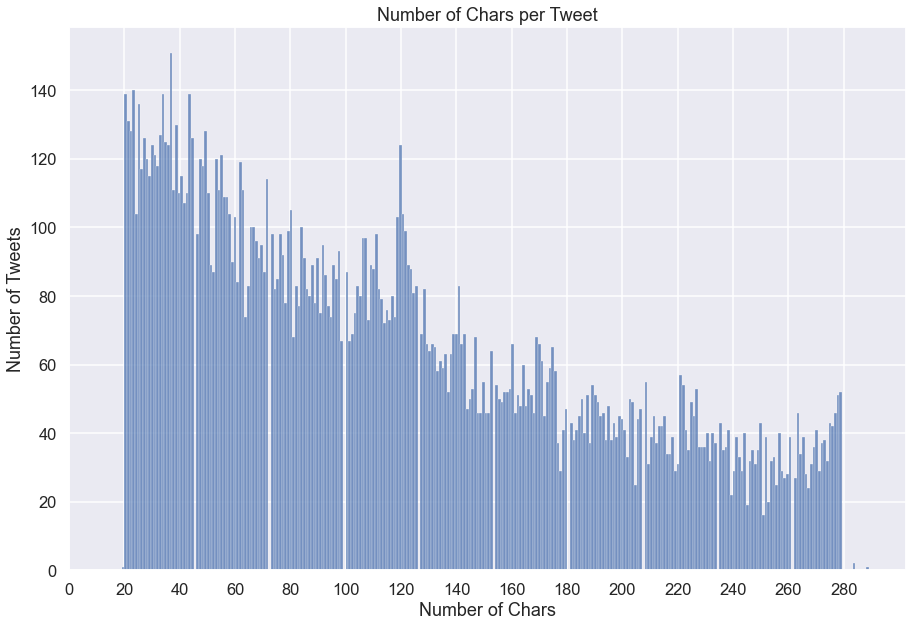

In [58]:
sns.histplot(df['text'].str.len(), bins=280)
plt.xticks(list(range(0, 290, 20)))
plt.xlabel('Number of Chars')
plt.ylabel('Number of Tweets')
plt.title('Number of Chars per Tweet');

###### Great, we can see that we practically do not have any tweets with less than 20 chars. Also, we can see that we have some tweets that exceed the 280 mark, and those are a few prepended tweets. And Distribution has evened out even more! Let's continue

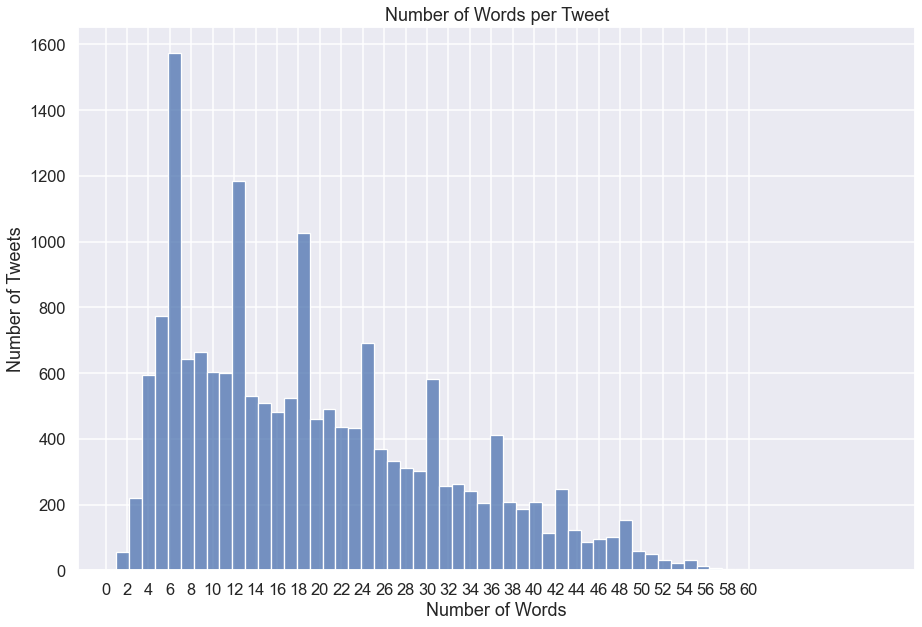

In [59]:
# let's look at the number of words per tweet
sns.histplot(df.text.str.split().map(lambda words: len(words)), bins=59)
plt.xticks(list(range(0, 61, 2)))
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.title('Number of Words per Tweet');

###### Let's take a closer look at the tweets with very high and very low word count.

In [60]:
# tweets with extremely low number of words
print(df.loc[df.text.str.split().map(lambda words: len(words)) < 4, 'text'].__len__())
df.loc[df.text.str.split().map(lambda words: len(words)) < 4, 'text'].sample(10)

275


4320                               Brandon crushed it!
5476                               What innovation....
31529     Photoshop.... Manipulation.... Propaganda...
21744                         Herrfurthplatz in Berlin
21182                             Grab the opportunity
19061                             floki is invincible 
32218                            Your favorite! Water!
30863                             Best bitcoin wallet?
23618       0x6930c8A84b8ABb1e0C675fC5c54b81C0Bbeb24d1
33141                   GoooOOoooooD Moooorrnnnning!!!
Name: text, dtype: object

In [61]:
# tweets with extremely high number of words
df.loc[df.text.str.split().map(lambda words: len(words)) > 55, 'text'].sample(10)

10038     Terrible. This did turn into a ponzi scheme. ...
19742     I think this is a decisive year for crypto: i...
20169     I think you should sell because it s going lo...
27782     Bitcoin and Terra Luna Disaster: 23 Dead..TUR...
24351     Akrasin, t a game MMORPG 3D x n x k t h p v i...
20461     My question is, if BTC goes to $60k -$70k in ...
6736      :men’s_room: Mark Zuckerberg ch nh th c kh i ...
15510     I do agree the limit is low, I think it s goo...
19999     Hey want to insult me, I ll insult you back. ...
32150     Did this go the way we wanted? No, it absolut...
Name: text, dtype: object

##### It seems that tweets with very high number of words are fine. However, tweets with a low word count consist of a lot of garbage. Let's try to deal with it.

In [62]:
# let's look at tweets that have 3 or fewer words and more than 28 chars. We are assuming that if on average each word is longer than 28/9 ~ 9.3 than it's a spam
df.loc[(df.text.str.len() > 28) & (df.text.str.split().map(lambda words: len(words)) <= 3), 'text'].sample(10)

16869     irena wonderfull :green_heart::green_heart::g...
5816      "innovation" :rolling_on_the_floor_laughing::...
33663     KeepFailingWithEveryTweet RageTweetingInProgress
29025     keepbuilding smart! :fire::sign_of_the_horns:...
33613           0xeFD6Bdfd25af087BdDb1338Bc4419136A3549011
24258          0x5A08D8214e4834C136C53f214DCa03c77901D46c 
20403                       bitcoin = PerpetualPonziScheme
11565                         KYC-free crypto Martercard: 
17662     CEEK VR coin:rocket::rocket::rocket::rocket::...
29880                        Agreat project Saylor:rocket:
Name: text, dtype: object

###### We can see that some of these behaviour is caused by attached demojized emojis, but if tweet has more emojis than words it might not hold much meaning. Great, it looks like we are able to filter out more spams! Let's drop such tweets from our df and visualize it once more.

In [63]:
to_drop = df.loc[(df.text.str.len() > 28) & (df.text.str.split().map(lambda words: len(words)) <= 3), 'text'].index.tolist()
df.drop(to_drop, axis=0, inplace=True)

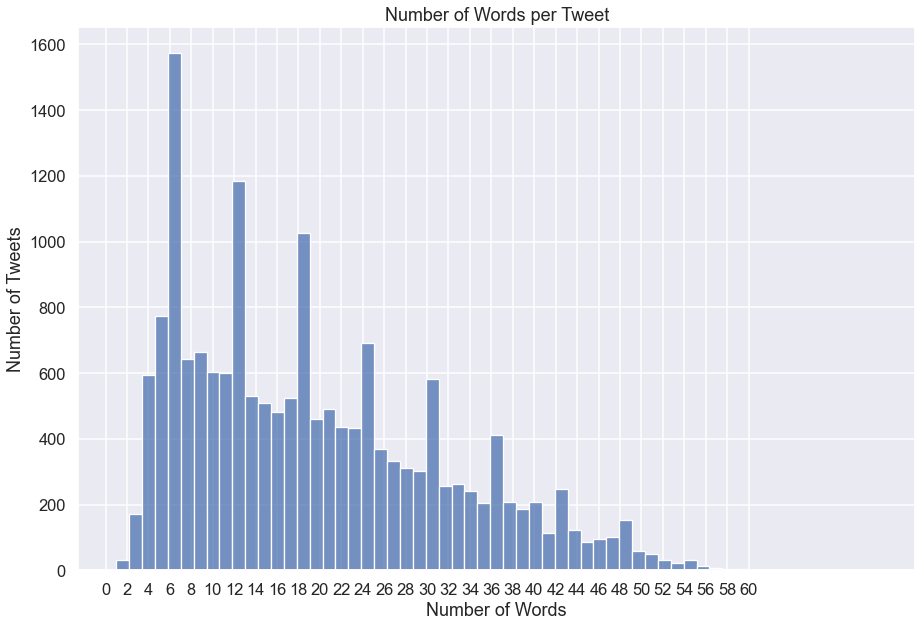

In [64]:
# let's look at the number of words per tweet again
sns.histplot(df.text.str.split().map(lambda words: len(words)), bins=59)
plt.xticks(list(range(0, 61, 2)))
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.title('Number of Words per Tweet');

In [65]:
# tweets we are left with that have less than 4 words
df.loc[df.text.str.split().map(lambda words: len(words)) <= 3, 'text'].sample(20)

8190             you misspelled gold
24446            goldensparrowtoken 
8825         Depressingly uneducated
22363            Can't teach stupid.
18028     Successfull project xrdoge
9232        America's Last Virgin...
7134             Malignant practices
32945      GM regulardoingirregular 
11290            $CAW Legion waiting
16746          ReSpOnSiBlE TaXaTiOn 
20698            Been holding awhile
30863           Best bitcoin wallet?
30713          Absolutely agree ;-) 
8378        btc isn't xrpthestandard
13877       BTC suppresses inflation
6938             Maybe keep posting?
9011             Nobody contacted me
20304       Speculators buy Bitcoin.
8477            Blocked for scamming
6420           Arbitrary Capricious.
Name: text, dtype: object

###### Alright, it seems like we filtered out most of the spams. Let's continue

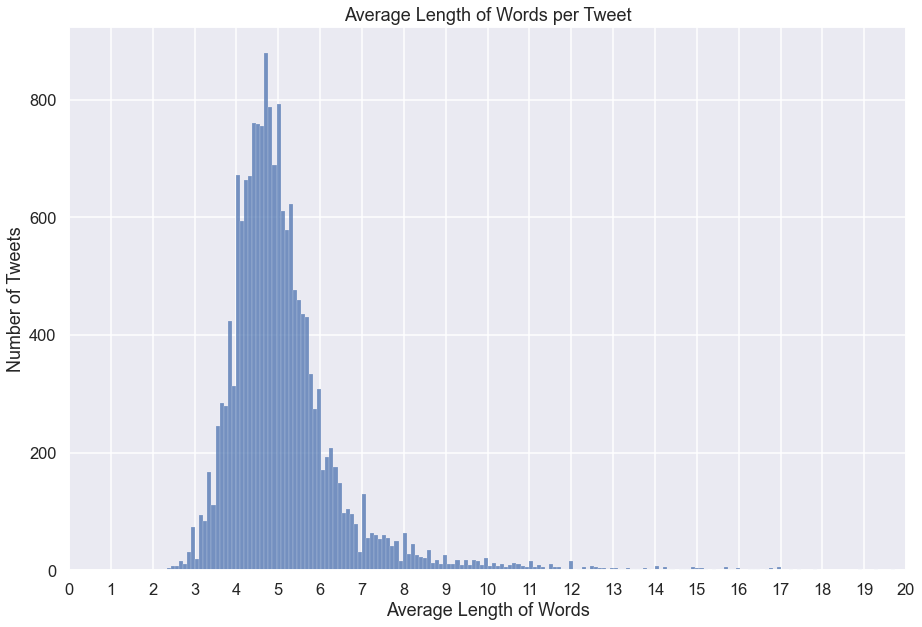

In [66]:
# let's check what is the average word length per tweet
sns.histplot(df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)))
plt.xticks(list(range(0, 30, 1)))
plt.xlim(0, 20)
plt.xlabel('Average Length of Words')
plt.ylabel('Number of Tweets')
plt.title('Average Length of Words per Tweet');

###### Let's take a closer look at the outliers

In [67]:
# tweets where average word length is more than 15
print('Approximate number of outliers is', df.loc[df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)) > 8, 'text'].__len__())
df.loc[df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)) > 15, 'text'].sample(10)

Approximate number of outliers is 759


5653      :rolling_on_the_floor_laughing::rolling_on_th...
32411     Gm to a beautiful day:dizzy::people_hugging::...
11012     Be wise, join :pinched_fingers_light_skin_ton...
5501      Cyber security enthusiast but you like eth:ro...
13513     SHIB DroverToken droverinu BabyDogeCoin babyd...
15992     does freedom tool know about censorship of th...
32755     Good morning, have a nice day:four_leaf_clove...
33814     Who pays for this? :rolling_on_the_floor_laug...
33383     Absolutely incredible :raising_hands_medium-l...
18463     CEEK VR CO N:rocket::rocket::rocket::rocket::...
Name: text, dtype: object

In [68]:
# tweets where average word length is less than 2.8
df.loc[df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)) < 2.8, 'text'].sample(10)

24184                        10 or 15? haha try 100 or 150
10925                                  cant it go to $25 ?
19112                                Sorry I m not a moron
12759                           WE KNOW !!! 6 K IS COMING 
22502                            Waiting for $ 20 k to buy
15781         Is it up to 200 or with cap gains up to 200?
9300                          If it s a spot ETF then yes.
4655                       It s the mask on one ear for me
24407     Akrasin, t a game MMORPG 3D x n x k t h p v i...
32488     I m so happy for you Mate I m glad you had a ...
Name: text, dtype: object

###### We can see that tweets with low average word length are fine for now. However, for tweets that have high average length, such behaviour is caused by demojizing emoji which does not create space in between the translated text. So we have to note that after demojizing we should split the translated text.

In [69]:
# NOTE: this is not the best regex since we will be creating spaces only between two emojis, but not an emoji and another word
df['text'].replace(r'::', ': :', regex=True, inplace=True)

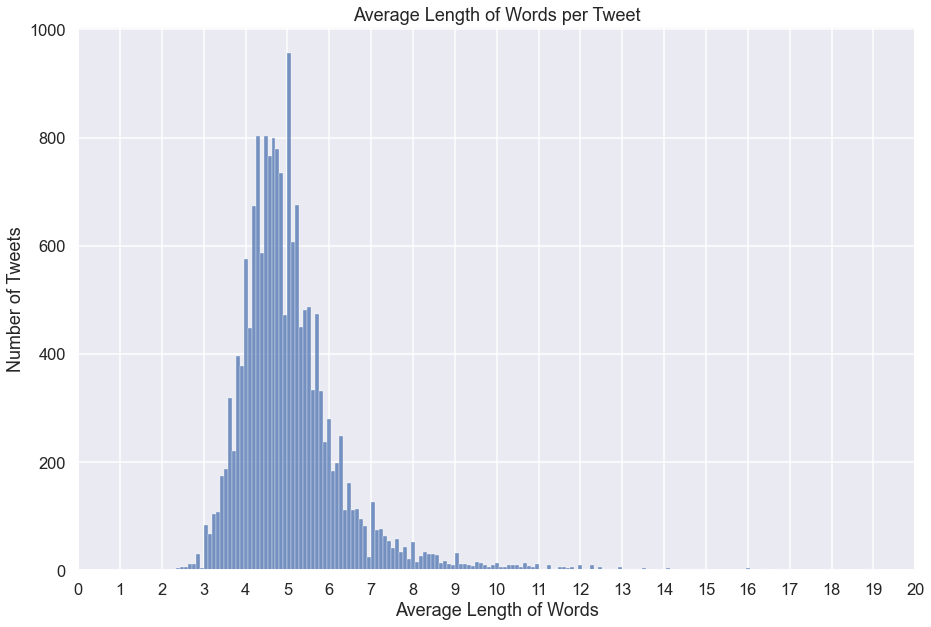

In [70]:
# now let's look at the distribution again
sns.histplot(df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)))
plt.xticks(list(range(0, 30, 1)))
plt.xlim(0, 20)
plt.xlabel('Average Length of Words')
plt.ylabel('Number of Tweets')
plt.title('Average Length of Words per Tweet');

In [71]:
print('Approximate number of outliers is', df.loc[df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)) > 8, 'text'].__len__())
df.loc[df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)) > 15, 'text']

Approximate number of outliers is 598


5537      Founder of bitcoin is 000000000019d6689c085ae...
5653      :rolling_on_the_floor_laughing: :rolling_on_t...
6114                            LoooooooooooooooooooooooL 
7390      Of course it's not true:rolling_on_the_floor_...
7938      Hows that working out?:rolling_on_the_floor_l...
15324     metaxlauncher NFT NFTs :smiling_face_with_hea...
15830     Dogecoin TO THE MOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
21698     Satoshi is a cheater..:face_with_tears_of_joy...
22197     Thank me later :backhand_index_pointing_down:...
22827     Join chat:speech_balloon: to start earn:backh...
24446                                  goldensparrowtoken 
25630     I. Am. Gasping. :rolling_on_the_floor_laughin...
27221     Hahahhahahhahahahahahha fuck you all XRP hate...
27488     JeremyVine JurassicWorldDominion APCPresident...
29538     :red_exclamation_mark: :red_exclamation_mark:...
30655     "Nice" f*cking scammer :rolling_on_the_floor_...
30872     :beaming_face_with_smiling_eyes: :beaming_fac.

In [72]:
df = df[~(df.text.str.split().map(lambda words: sum(len(word) for word in words)/len(words)) > 15)]

###### Great, we cut the number of outliers by more than 20%. We are left with small number of tweets that still exceed 15 chars per word. They look spamy to me so will get rid such in our pipeline as well.

#### Our dataframe looks much cleaner now! Let's visualize most common words and ngrams!

In [73]:
stopwords = nltk.corpus.stopwords.words('english')
def get_corpus(dataframe):
    text = dataframe['text'].str.split().values.tolist()
    return [word for row in text for word in row]
corpus = get_corpus(df)

In [74]:
def plot_stop_words(corp):
    stop_words = defaultdict(int)
    for word in corp:
        if word.lower() in stopwords:
            stop_words[word] += 1
    stop_words_sorted = sorted(stop_words.items(), key=lambda item: item[1], reverse=True)[:20]
    sns.barplot(x='index', y=1, data=pd.DataFrame({k: v for k, v in stop_words_sorted}, index=[1]).T.reset_index())
    plt.title('Most Common Stop Words')
    plt.ylabel('Count')
    plt.xlabel('Stop Words')
    plt.show()

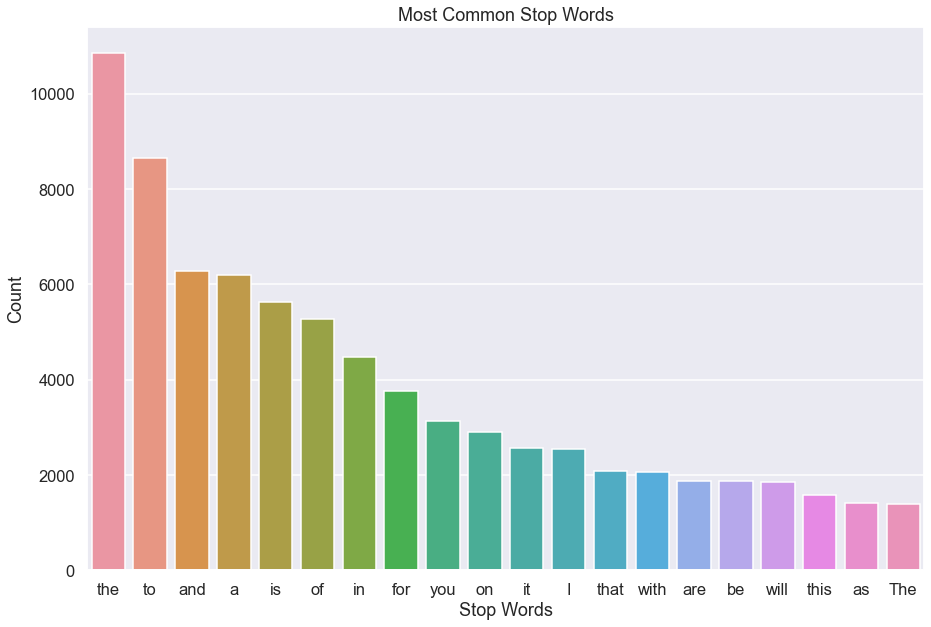

In [75]:
plot_stop_words(corpus)

In [76]:
# now lets plot most common non stopwords
def plot_most_common_words(corp, slice_=slice(0, 20)):
    counter = Counter(corp)
    most_common_words = counter.most_common()
    most_common_words = [(word, count) for word, count in most_common_words if word.lower() not in stopwords]
    sns.barplot(y='index', x=1, data=pd.DataFrame({word: count for word, count in most_common_words[slice_]}, index=[1]).T.reset_index(), orient='h')
    plt.title('Most Common Words')
    plt.ylabel('Words')
    plt.xlabel('Count')
    # plt.xticks(list(range(0, 2500, 200)))
    plt.show()

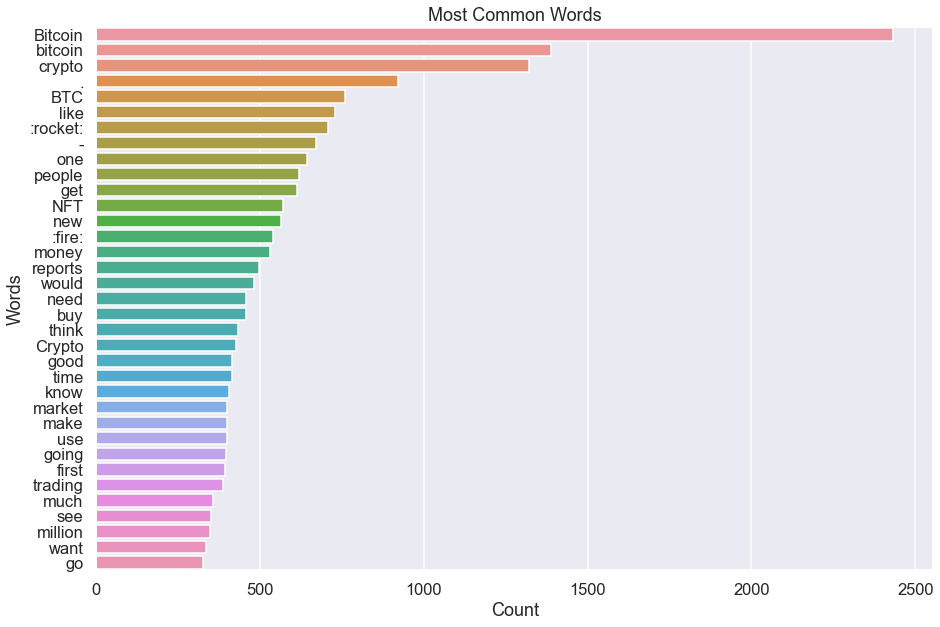

In [77]:
plot_most_common_words(corpus, slice(0, 35))

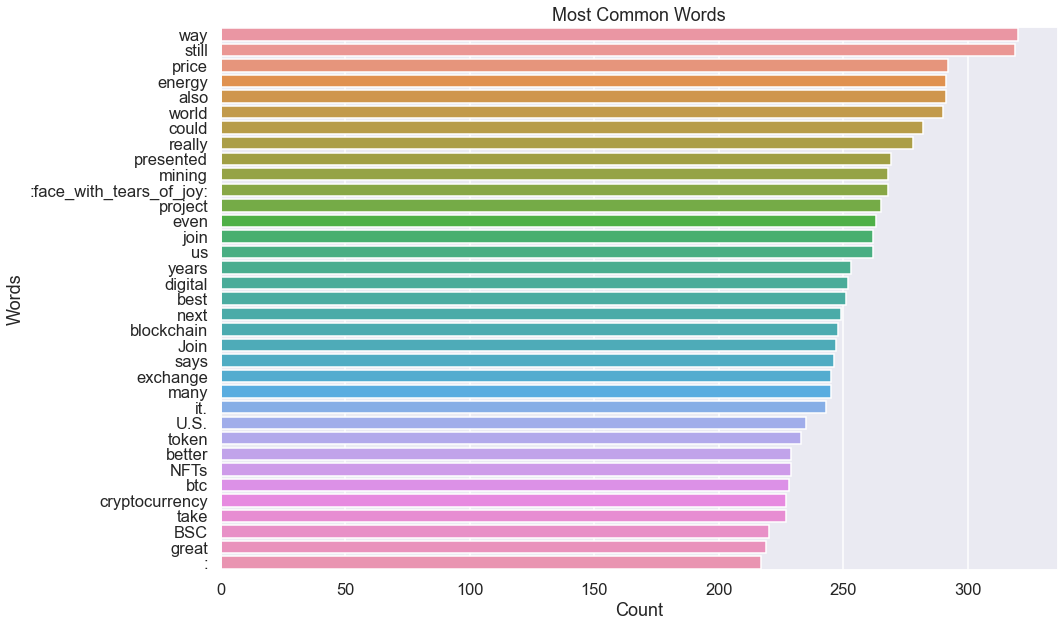

In [78]:
plot_most_common_words(corpus, slice(35, 70))

###### Great, we clearly can see that most common topic is btc. Also, we need to do some text cleaning!

In [79]:
def n_grammer(corp, n=2, most_common=10, title='Bigram'):
    vec = CountVectorizer(ngram_range=(n, n))
    bag_of_words = vec.fit_transform(corp)
    sum_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    word_freq =  sorted(word_freq, key=lambda item: item[1], reverse=True)[:most_common]
    word_freq = {k: v for k, v in word_freq}
    sns.barplot(y='index', x=1, data=pd.DataFrame(word_freq, index=[1]).T.reset_index(), orient='h')
    plt.title(title)
    plt.ylabel('Combinations')
    plt.xlabel('Count')
    plt.show()

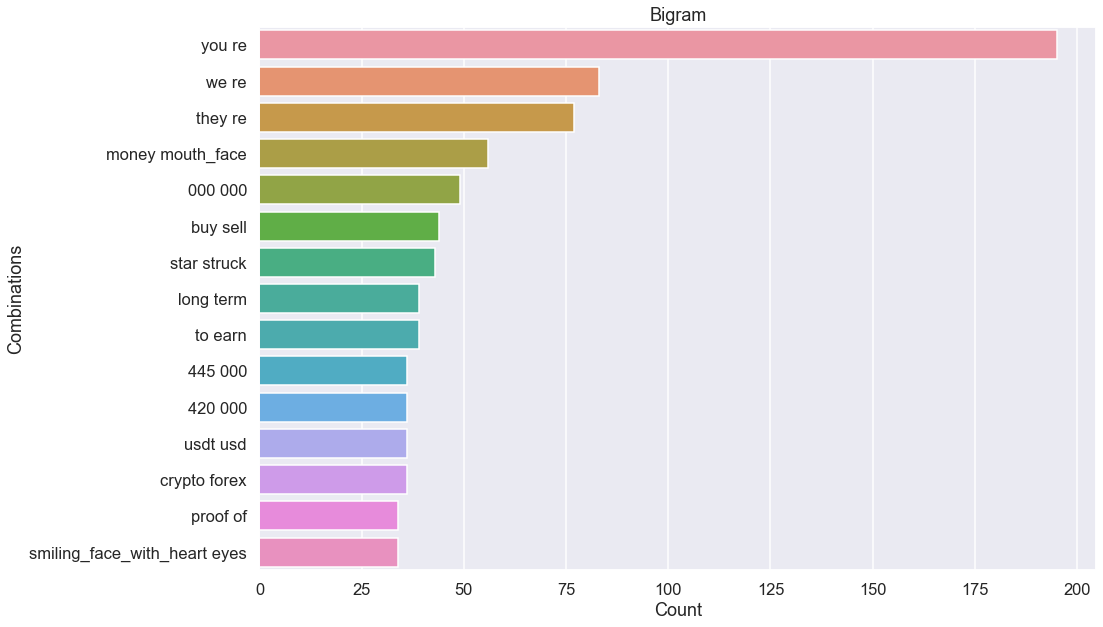

In [80]:
n_grammer(corpus, n=2, most_common=15, title='Bigram')

###### We see that we require more cleaning here as well e.g. "you re" to "you are" etc.

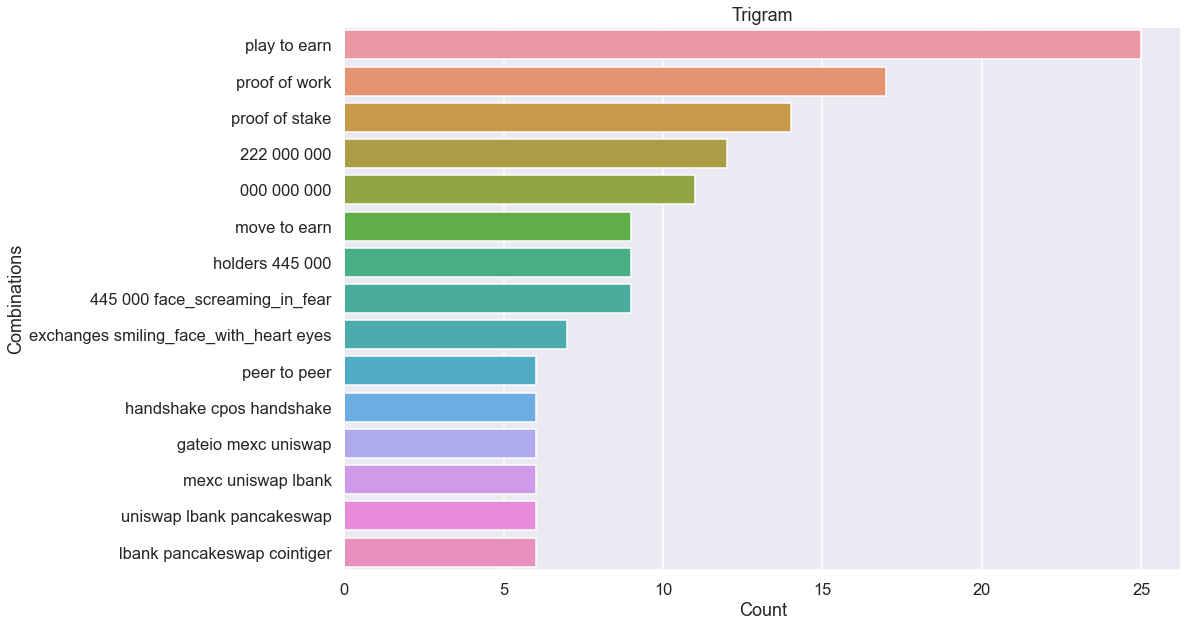

In [81]:
n_grammer(corpus, n=3, most_common=15, title='Trigram')

###### Also, we should check some of these phrases to make sure they are not spam tweets

In [82]:
# let's clean up some of the mess that we found here
def preprocess_tweets(row):
    row = str(row)
    row = re.sub(r'\s+', ' ', row)
    row = row.replace(' re ', ' are ').replace("'re", ' are').replace("I m ", "I am ").replace("'m " , ' am ').replace("n't", ' not').replace('cannot', 'can not').replace("'ve", ' have').replace("'s", ' is').replace("'ll ", ' will ').replace(' .', '.').replace(' U ', ' You ').replace(' u ', ' you ')

    row = row.replace('$', ' dollar ').replace('€', 'euro').replace('bitcoin', 'Bitcoin').replace('BTC', 'Bitcoin').replace('btc', 'Bitcoin').replace('Btc', 'Bitcoin').replace('Crypto ', 'cryptocurrency ').replace('crypto ', 'cryptocurrency ')

    # USA
    row = re.sub(r'(^| )US($| )', ' USA ', row)
    row = re.sub(r'(^| )U\.S\.A($| )', ' USA ', row)
    row = re.sub(r'(^| )U\.S\.($| )', ' USA ', row)
    row = re.sub(r'(^| )u\.s\.($| )', ' USA ', row)
    row = re.sub(r'(^| )U\.S($| )', ' USA ', row)
    row = re.sub(r'(^| )u\.s($| )', ' USA ', row)
    row = re.sub(r'(^| )US($| )', ' USA ', row)

    row = row.replace('Bitcoin Bitcoin', 'Bitcoin')  # prevent from "#BTC #Bitcoin"
    row = re.sub(r'\s+', ' ', row)              # get rid of extra spaces
    row = re.sub('(?<=\d) (?=\d)', '', row)     # attaching neighbouring numbers
    row = re.sub('(?<=\d),(?=\d)', '', row)     # attaching neighbouring numbers
    row = re.sub(r'^\. ', '', row)              # get rid of the dots in the beginning
    return row

In [83]:
df.loc[:, 'text'] = df.text.apply(preprocess_tweets)

In [84]:
corpus1 = get_corpus(df)

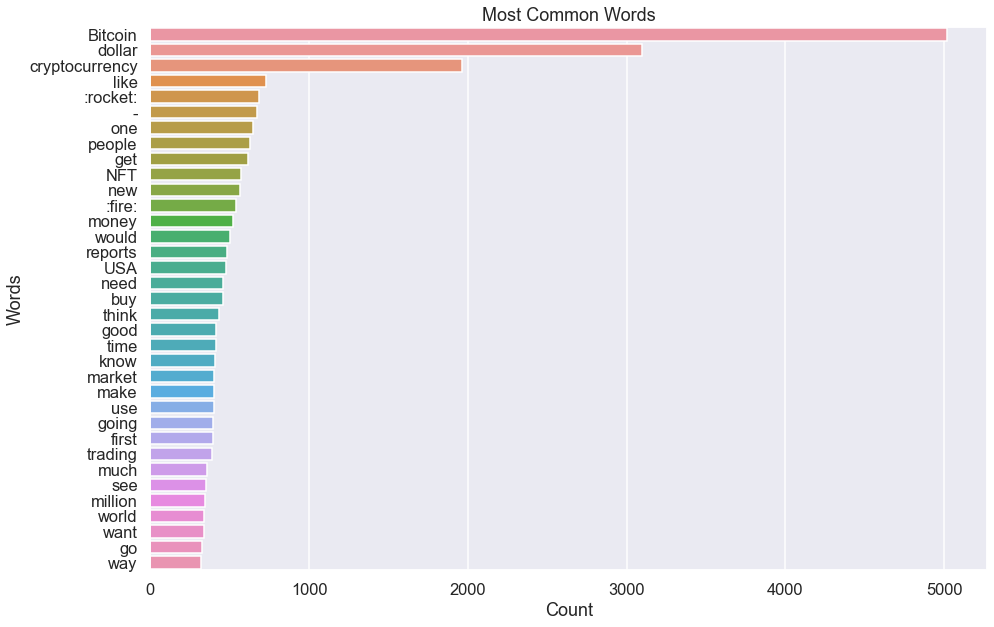

In [85]:
plot_most_common_words(corpus1, slice(35))

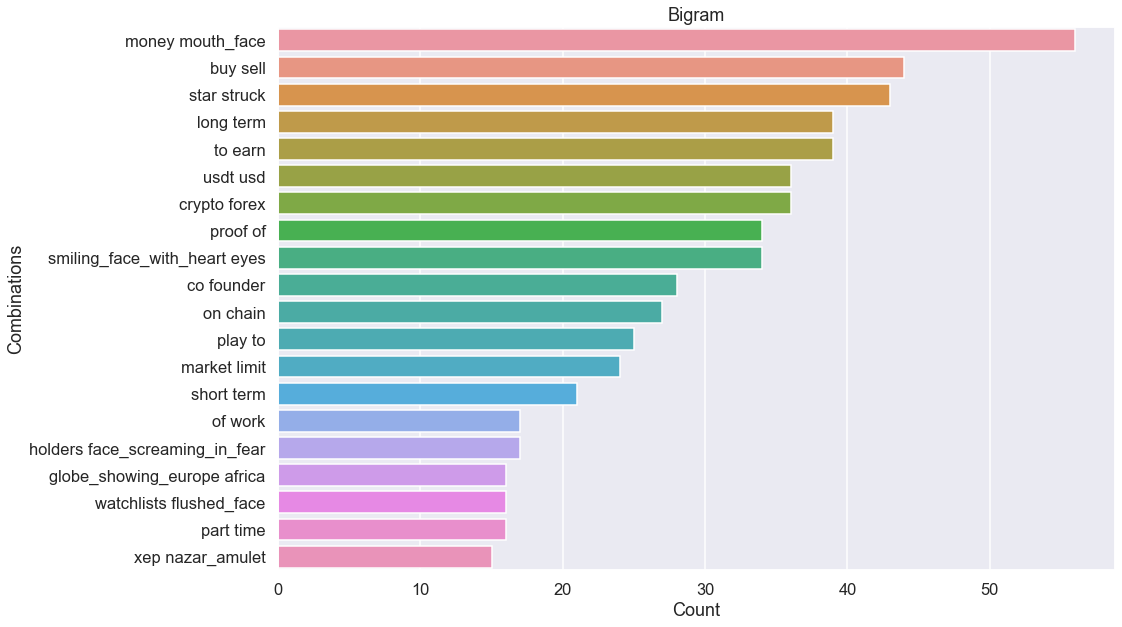

In [86]:
n_grammer(corpus1, 2, 20)

###### Some of it looks a little spamy but in general it looks fine to me, a lot of emojis.

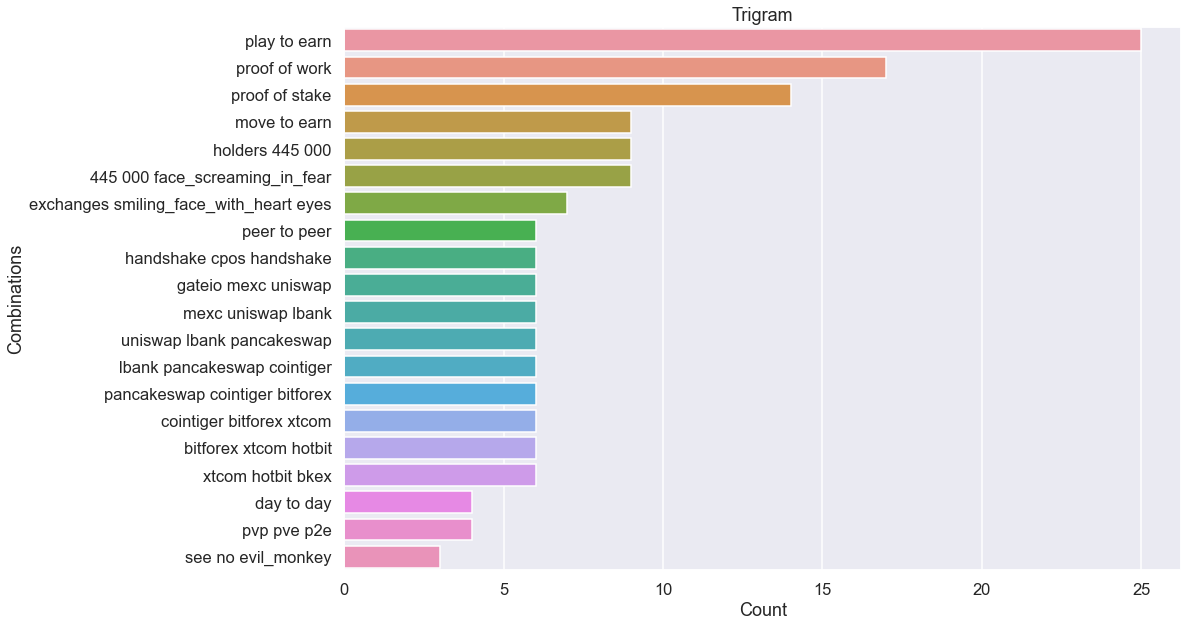

In [87]:
n_grammer(corpus1, 3, 20, title='Trigram')

###### It looks like trigram discovers more spam tweets, but the count seems to be very insignificant compare to the size of our dataframe. Also since this dataframe will not be constant (tweets will be streamed every day), such insignificant patterns will be difficult to cath. Let's keep it in mind and move on for now.

In [88]:
df.loc[df.text.str.contains(r'(?=.*play)(?=.*to)(?=.*earn)', regex=True), 'text'].sample(10)

10894     Check this out guys the future of play2earn w...
21481     The LAST minting session for CrossTheAges is ...
26416     is the first ever play to gaming platform wit...
25096     AZWorld SocialFi2Earn AZW Best project to ear...
22360     Check out our new p2e game! :trophy: Sports g...
26091     WSG MilkyWayDefi NEXT 100 X ?? 1000X ?? wsg +...
8181      Any holder of dollar RUBY tokens here play on...
2203     Gaming and cryptocurrency are increasingly get...
10693     Hey guys, check out An amazing play to earn p...
17930     I am wondering why there is no such news abou...
Name: text, dtype: object

###### Great! Now it looks much cleaner, we can see word trends of our corpus. Let's plot the word cloud and see what it looks!

In [89]:
stop_words = set(STOPWORDS)
def plot_wordlcloud(corp):
    word_cloud = WordCloud(background_color='white', stopwords=stopwords, max_words=100, max_font_size=30, scale=3, random_state=5)
    word_cloud = word_cloud.generate(str(corp))
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.show()

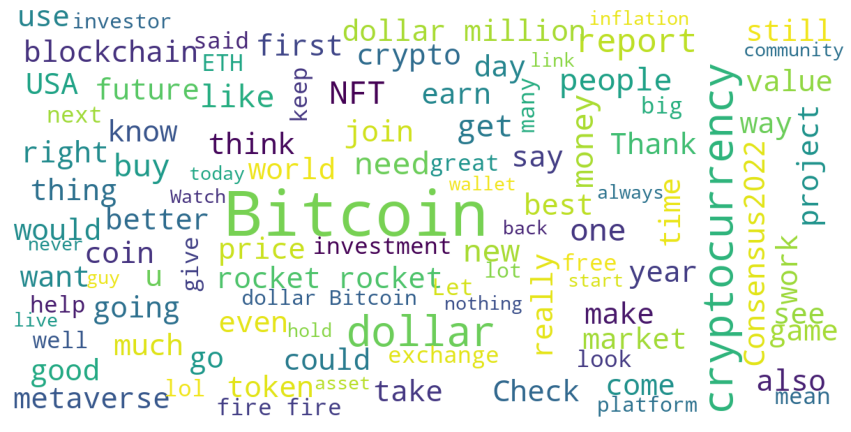

In [90]:
plot_wordlcloud(' '.join(corpus1))

###### It looks quite clean and on topic!
#### Let's discover more insights about our tweets using named entity recognition!

In [91]:
nlp = spacy.load('en_core_web_sm')

In [92]:
def get_ner(row, ent=None):
    doc = nlp(row)
    if not ent:
        return [item.label_ for item in doc.ents]
    if ent:
        return [item.text for item in doc.ents if item.label_ == ent]

In [93]:
df['ner'] = df['text'].apply(get_ner)

In [94]:
df['ner'].head(10)

0                           [CARDINAL, NORP]
1                                     [DATE]
2     [NORP, ORG, DATE, ORG, ORG, ORG, DATE]
3                                         []
5                                [GPE, DATE]
6                                 [CARDINAL]
7                                         []
8                                 [LAW, ORG]
9                                 [GPE, ORG]
10           [NORP, CARDINAL, ORG, CARDINAL]
Name: ner, dtype: object

In [95]:
named_entities = [ent for row in df['ner'].values.tolist() for ent in row]
ent_counter = Counter(named_entities)
most_common_ent = ent_counter.most_common()
most_common_ent = [(word, count) for word, count in most_common_ent]

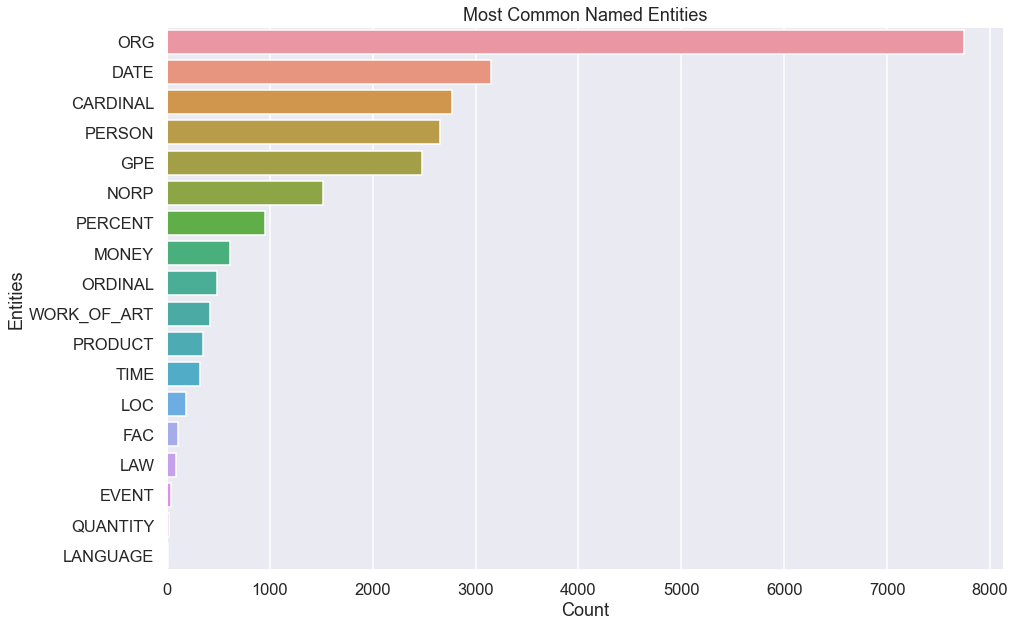

In [96]:
sns.barplot(y='index', x=1, data=pd.DataFrame({word: count for word, count in most_common_ent}, index=[1]).T.reset_index(), orient='h')
plt.title('Most Common Named Entities')
plt.ylabel('Entities')
plt.xlabel('Count')
plt.show()

* ORG - companies, entities, institutions
* DATE - absolute or relative dates or periods
* CARDINAL - Numerals that do not fall under another type
* PERSON - people, including fictional
* GPE - countries, cities, states
* NORP - nationalities or religious or political groups
* PERCENT - percent including '%'
* MONEY - monetary values, including unit
* ORDINAL -  'first', 'second', etc.
* WORK_OF_ART - titles of books, songs, etc.
* PRODUCT - objects, vehicles, foods, etc. (not services)
* TIME - times smaller than a day
* LOC - Non-GPE locations, mountain ranges, bodies of water.
* FAC - buildings, airports, highways, bridges, etc.
* LAW - named documents made into law.
* EVENT - Named hurricanes, battles, wars, sport events, etc.
* QUANTITY - measurements as of weight or distance
* LANGUAGE - any named language

###### We can see that organizations entities dominate our tweets. Let's take a closer look at their examples

In [97]:
def plot_most_common_ent_word(most_com, title):
    sns.barplot(y='index', x=1, data=pd.DataFrame({word: count for word, count in most_com}, index=[1]).T.reset_index(), orient='h')
    plt.title(f'Most Common {title} Entities')
    plt.ylabel('Entities')
    plt.xlabel('Count')
    plt.show()

In [98]:
org = df['text'].apply(lambda row: get_ner(row, 'ORG'))
org_ents = [word for row in org for word in row]

In [99]:
org_counter = Counter(org_ents)
most_common_org = org_counter.most_common()
most_common_org = [(word, count) for word, count in most_common_org[:30]]

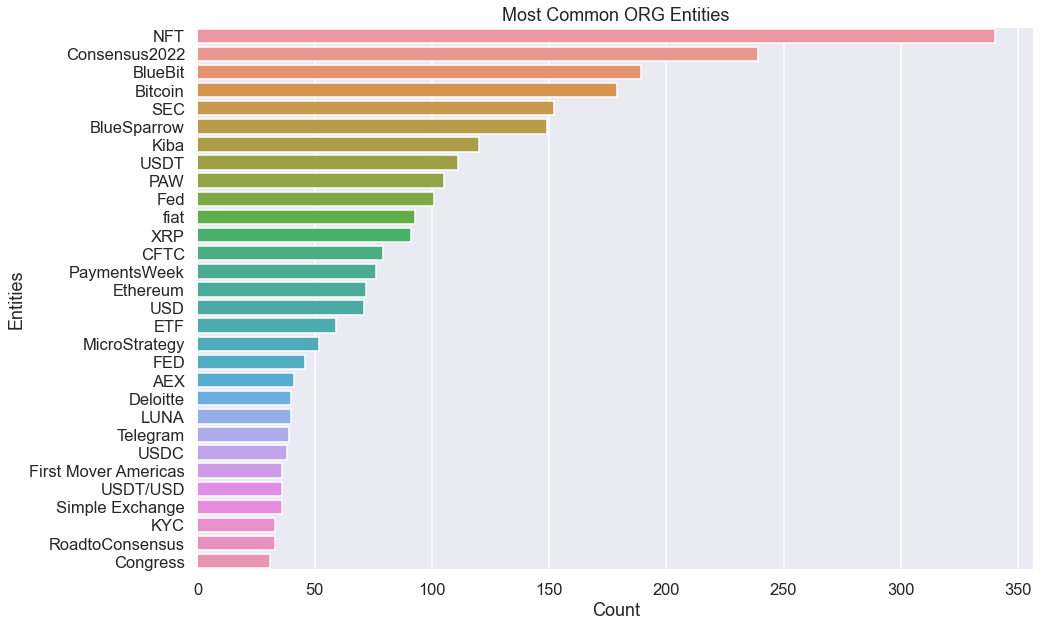

In [100]:
plot_most_common_ent_word(most_common_org, 'ORG')

###### We can observe that most of the organization entities that spacy picks up on are different cryptocurrencies. Interestingly, 'Bitcoin' has by far the highest word count but its fourth on this graph. Something to look into!
###### Now let's plot some other examples of named entities.

In [101]:
date_ent = df['text'].apply(lambda row: get_ner(row, 'DATE'))
date_ents = [word for row in date_ent for word in row]

In [102]:
date_counter = Counter(date_ents)
most_common_dates = date_counter.most_common()
most_common_dates = [(word, count) for word, count in most_common_dates[:30]]

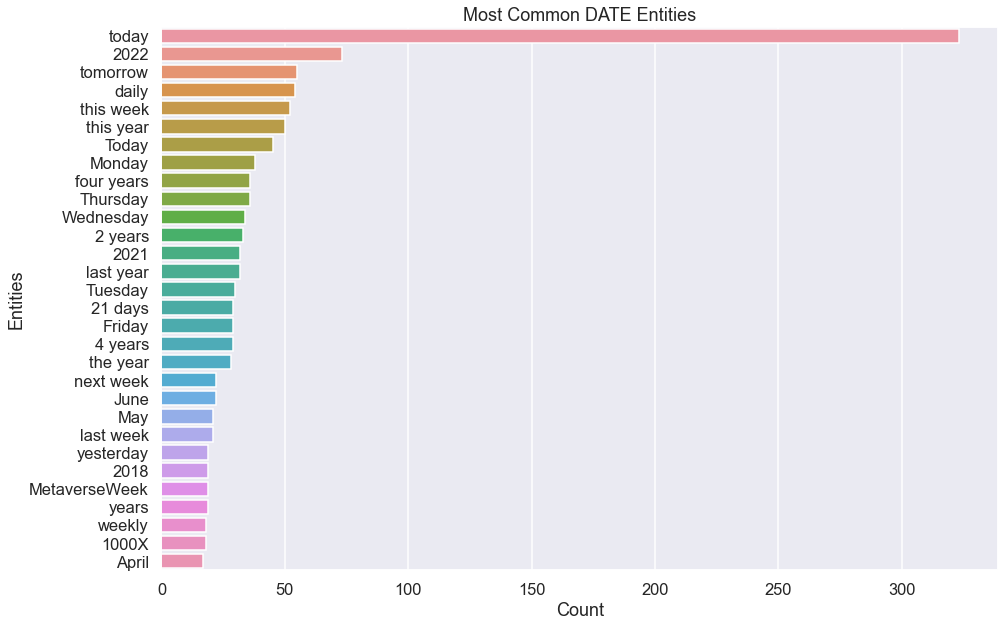

In [103]:
plot_most_common_ent_word(most_common_dates, 'DATE')

###### I think that this bar plot is quite interesting because it signifies the urgency and volatility of the crypto market

In [104]:
person_ent = df['text'].apply(lambda row: get_ner(row, 'PERSON'))
person_ents = [word for row in person_ent for word in row]

In [105]:
person_counter = Counter(person_ents)
most_common_person = person_counter.most_common()
most_common_person = [(word, count) for word, count in most_common_person[:30]]

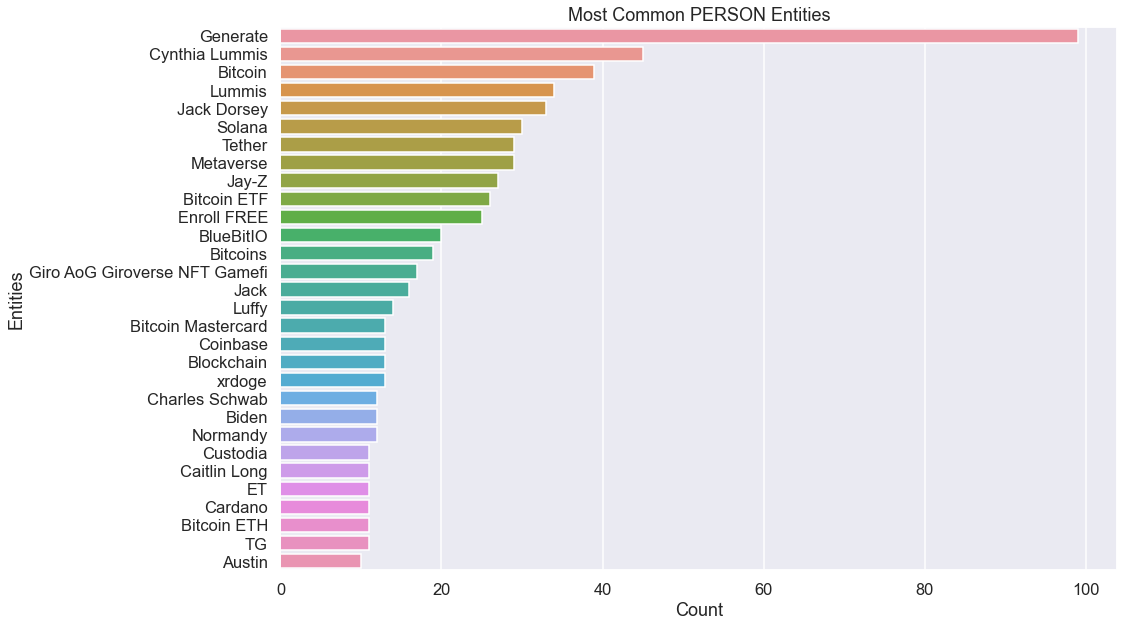

In [106]:
plot_most_common_ent_word(most_common_person, 'PERSON')

###### We can see names that probably have some significant influence on the market like (Cynthia Lummis, Jack Dorsey, Biden and others)

In [107]:
gpe_ent = df['text'].apply(lambda row: get_ner(row, 'GPE'))
gpe_ents = [word for row in gpe_ent for word in row]

In [108]:
gpe_counter = Counter(gpe_ents)
most_common_gpe = gpe_counter.most_common()
most_common_gpe = [(word, count) for word, count in most_common_gpe[:30]]

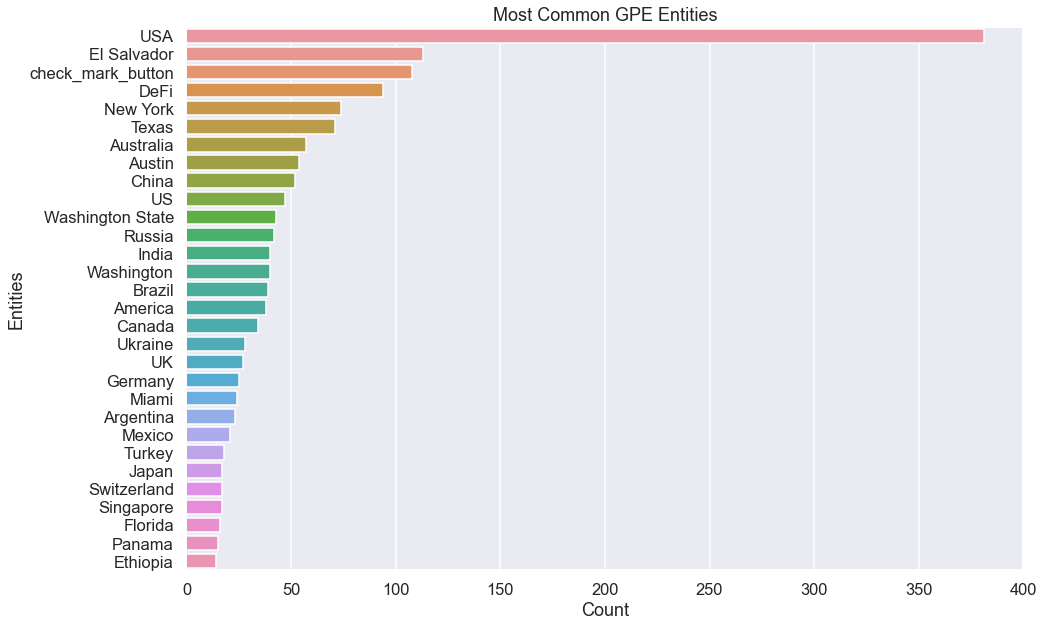

In [109]:
plot_most_common_ent_word(most_common_gpe, 'GPE')

###### We can see countries and states that are involved with cryptomarket the most.

###### I think this is a good point to stop. We have found a lot of patterns and information in our collected tweets. At this point our text data looks a lot cleaner. Therefore, let's summarize all the preprocessing steps that we should apply in our preprocessing pipeline. I want to create & apply preprocessing pipeline to our data and then continue EDA on other features of our dataframe in another notebook.
1. Remove common patterns:
    * mentions "@+"
    * retweets "RT"
    * BREAKING:/BREAKING
    * JUST IN:/JUST IN
    * TOMORROW:/TOMORROW
    * COMING UP:/ COMING UP
    * LIVE:/LIVE
    * ICYMI:/ICYMI
    * NEW:/NEW
    * hashtags "#"
    * links "http+"
    * bad chars (not ascii/emoji)
    * whitespace chars
    * strip extra spaces
    *
2. Filter out spam 1.0:
    * duplicated text more than twice
    * empty strings
    * have 'gm|Gm|GM|' and char count < 20
    * have 'Thank me later'
    * (have char count < 20) & (do not contain adjectives|adverbs)
    *
3. Prepend original tweets to replies if reply char count < 20 (all of them must contain JJ|RB)
    * drop row if reply:
        * is the original tweet
        * original tweet is not found (nan)
        * after prepending original tweet char count < 20
4. Convert emoji to text
    * split emoji before converting
5. Filter out spam 2.0:
    * tweet char count > 280
    * (tweet word count < 4) & (tweet char count > 28)
    *  tweets have average word length > 15
6. Start text cleaning (at this point most of the spam should be gone):
    * strip space (double check)
    * correct contractions (use contractions library)
    * strip leading dots (seems to be a common pattern)
    * correct slang
        * u > you
        * U > You
        * look into other common slangs
    * correct lingo
        * btc > Bitcoin
        * Btc > Bitcoin
        * bitcoin > Bitcoin
        * Crypto > cryptocurrency
        * crypto > cryptocurrency
        * U.S. > USA
        * US > USA
        * $ > dollar
        * £ > pounds
        * € > euro
    * other
        * 'Bitcoin Bitcoin', 'Bitcoin' – prevent from "#BTC #Bitcoin"
        * attaching neighbouring numbers (with coma or space in between)
    * strip of extra spaces again (double check)
###### I think that will be the order of preprocessing in the pipeline. I might add or change things later.